In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
%config InlineBackend.figure_format = 'retina'

# 📊 Загрузка данных

**Данные**: OHLCV свечи + новости по 19 российским тикерам (2020-2025)

**Задача**: Прогноз доходности на 1d и 20d горизонты с метриками MAE, Brier, DA

In [87]:
# Загрузка данных
c1 = pd.read_csv('./forecast_data/candles.csv')
c2 = pd.read_csv('./forecast_data/candles_2.csv')
n1 = pd.read_csv('./forecast_data/news.csv')
n2 = pd.read_csv('./forecast_data/news_2.csv')

candles = pd.concat([c1, c2], ignore_index=True)
news = pd.concat([n1, n2], ignore_index=True)

candles['date'] = pd.to_datetime(candles['begin'])
news['date'] = pd.to_datetime(news['publish_date'])

# Удаление дубликатов
candles = candles.drop_duplicates(subset=['ticker', 'begin']).sort_values(['ticker', 'date']).reset_index(drop=True)

print(f"Candles: {candles.shape}")
print(f"News: {news.shape}")
print(f"Date range candles: {candles['date'].min().date()} - {candles['date'].max().date()}")
print(f"Date range news: {news['date'].min().date()} - {news['date'].max().date()}")
print(f"Tickers: {sorted(candles['ticker'].unique())}")

Candles: (25602, 8)
News: (27455, 5)
Date range candles: 2020-06-19 - 2025-09-08
Date range news: 2020-01-01 - 2025-09-06
Tickers: ['AFLT', 'ALRS', 'CHMF', 'GAZP', 'GMKN', 'LKOH', 'MAGN', 'MGNT', 'MOEX', 'MTSS', 'NVTK', 'PHOR', 'PLZL', 'ROSN', 'RUAL', 'SBER', 'SIBN', 'T', 'VTBR']


# 🔍 EDA

Базовый анализ данных:
- Структура и покрытие
- Стационарность доходностей
- Корреляции между тикерами
- Влияние новостей на волатильность

In [88]:
# Структура данных
print("="*80)
print("CANDLES DATA STRUCTURE")
print("="*80)
print(candles.info())
print("\nПервые строки:")
print(candles.head())
print("\nРаспределение тикеров:")
print(candles['ticker'].value_counts())
print(f"\nМин/Макс торговых дней на тикер: {candles.groupby('ticker').size().min()} / {candles.groupby('ticker').size().max()}")

CANDLES DATA STRUCTURE
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25602 entries, 0 to 25601
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   open    25602 non-null  float64       
 1   close   25602 non-null  float64       
 2   high    25602 non-null  float64       
 3   low     25602 non-null  float64       
 4   volume  25602 non-null  int64         
 5   begin   25602 non-null  object        
 6   ticker  25602 non-null  object        
 7   date    25602 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 1.6+ MB
None

Первые строки:
    open  close   high    low    volume       begin ticker       date
0  81.50  81.70  83.20  81.16  29755530  2020-06-19   AFLT 2020-06-19
1  81.72  82.10  83.98  80.26  18502950  2020-06-22   AFLT 2020-06-22
2  82.04  81.20  82.48  80.40  16848930  2020-06-23   AFLT 2020-06-23
3  79.78  80.58  80.80  78.22  21559860  2020-0

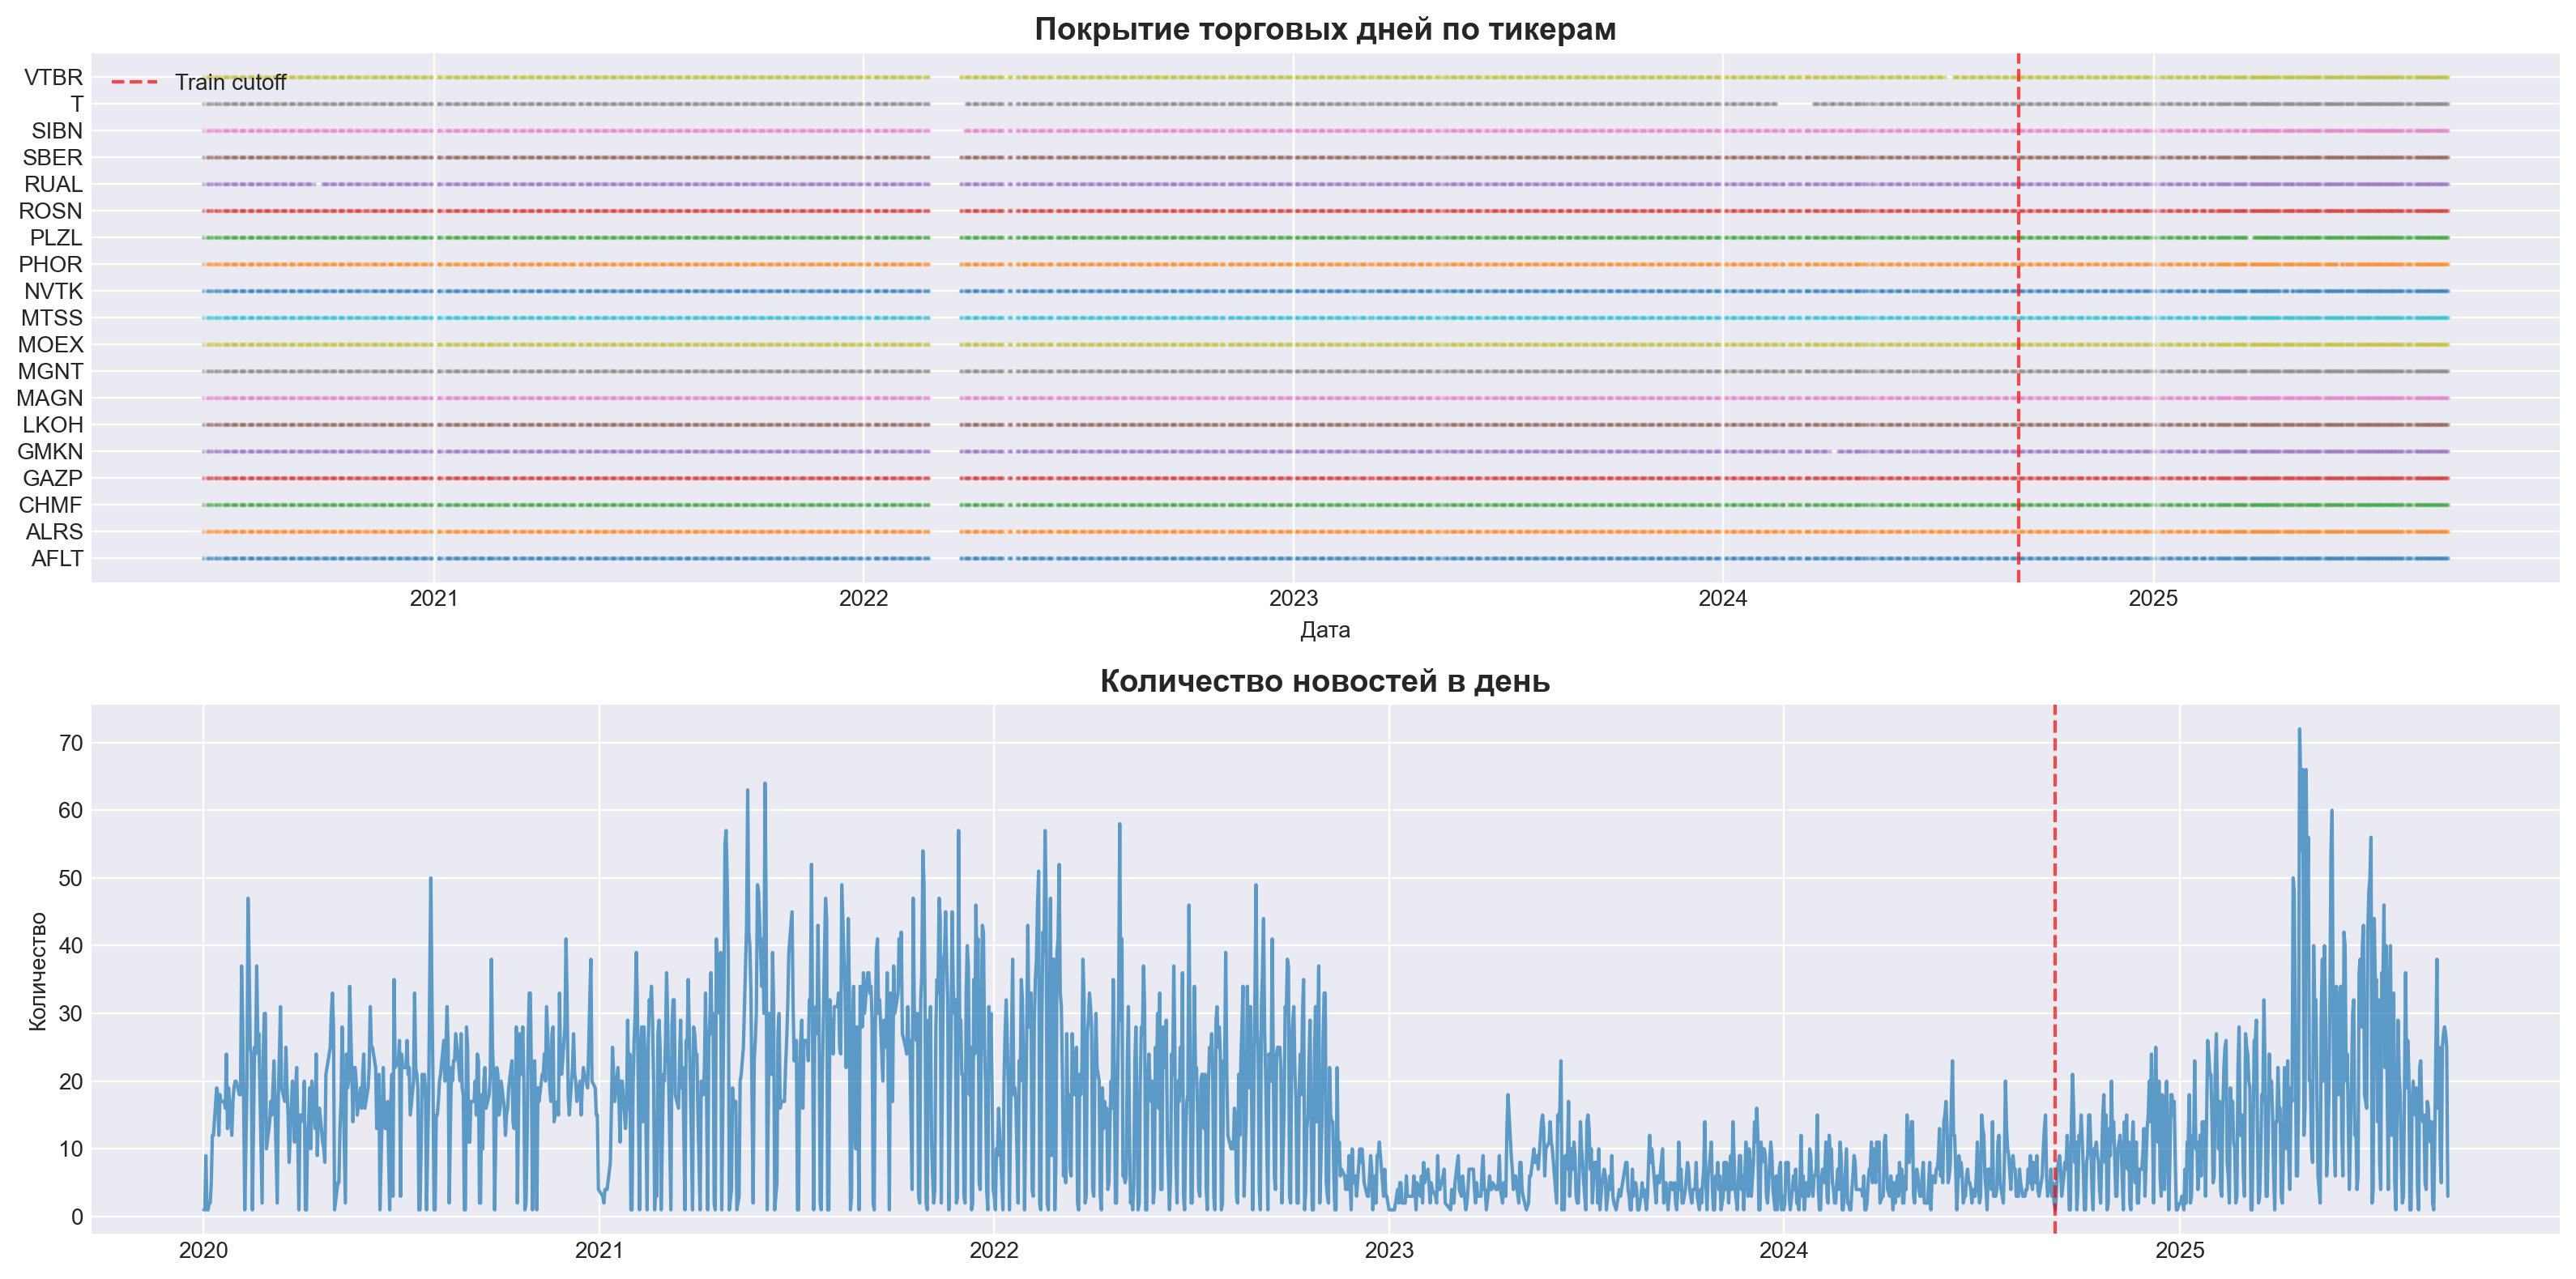

Новостей в день: mean=15.1, median=12, max=72


In [89]:
# Покрытие данных
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# График торговых дней по тикерам
for ticker in sorted(candles['ticker'].unique()):
    df_t = candles[candles['ticker']==ticker]
    axes[0].scatter(df_t['date'], [ticker]*len(df_t), alpha=0.3, s=1)
axes[0].set_title('Покрытие торговых дней по тикерам', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Дата')
axes[0].axvline(pd.Timestamp('2024-09-08'), color='red', linestyle='--', alpha=0.7, label='Train cutoff')
axes[0].legend()

# Таймлайн новостей
news_daily = news.groupby(news['date'].dt.date).size()
axes[1].plot(pd.to_datetime(news_daily.index), news_daily.values, alpha=0.7)
axes[1].set_title('Количество новостей в день', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Количество')
axes[1].axvline(pd.Timestamp('2024-09-08'), color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print(f"Новостей в день: mean={news_daily.mean():.1f}, median={news_daily.median():.0f}, max={news_daily.max()}")

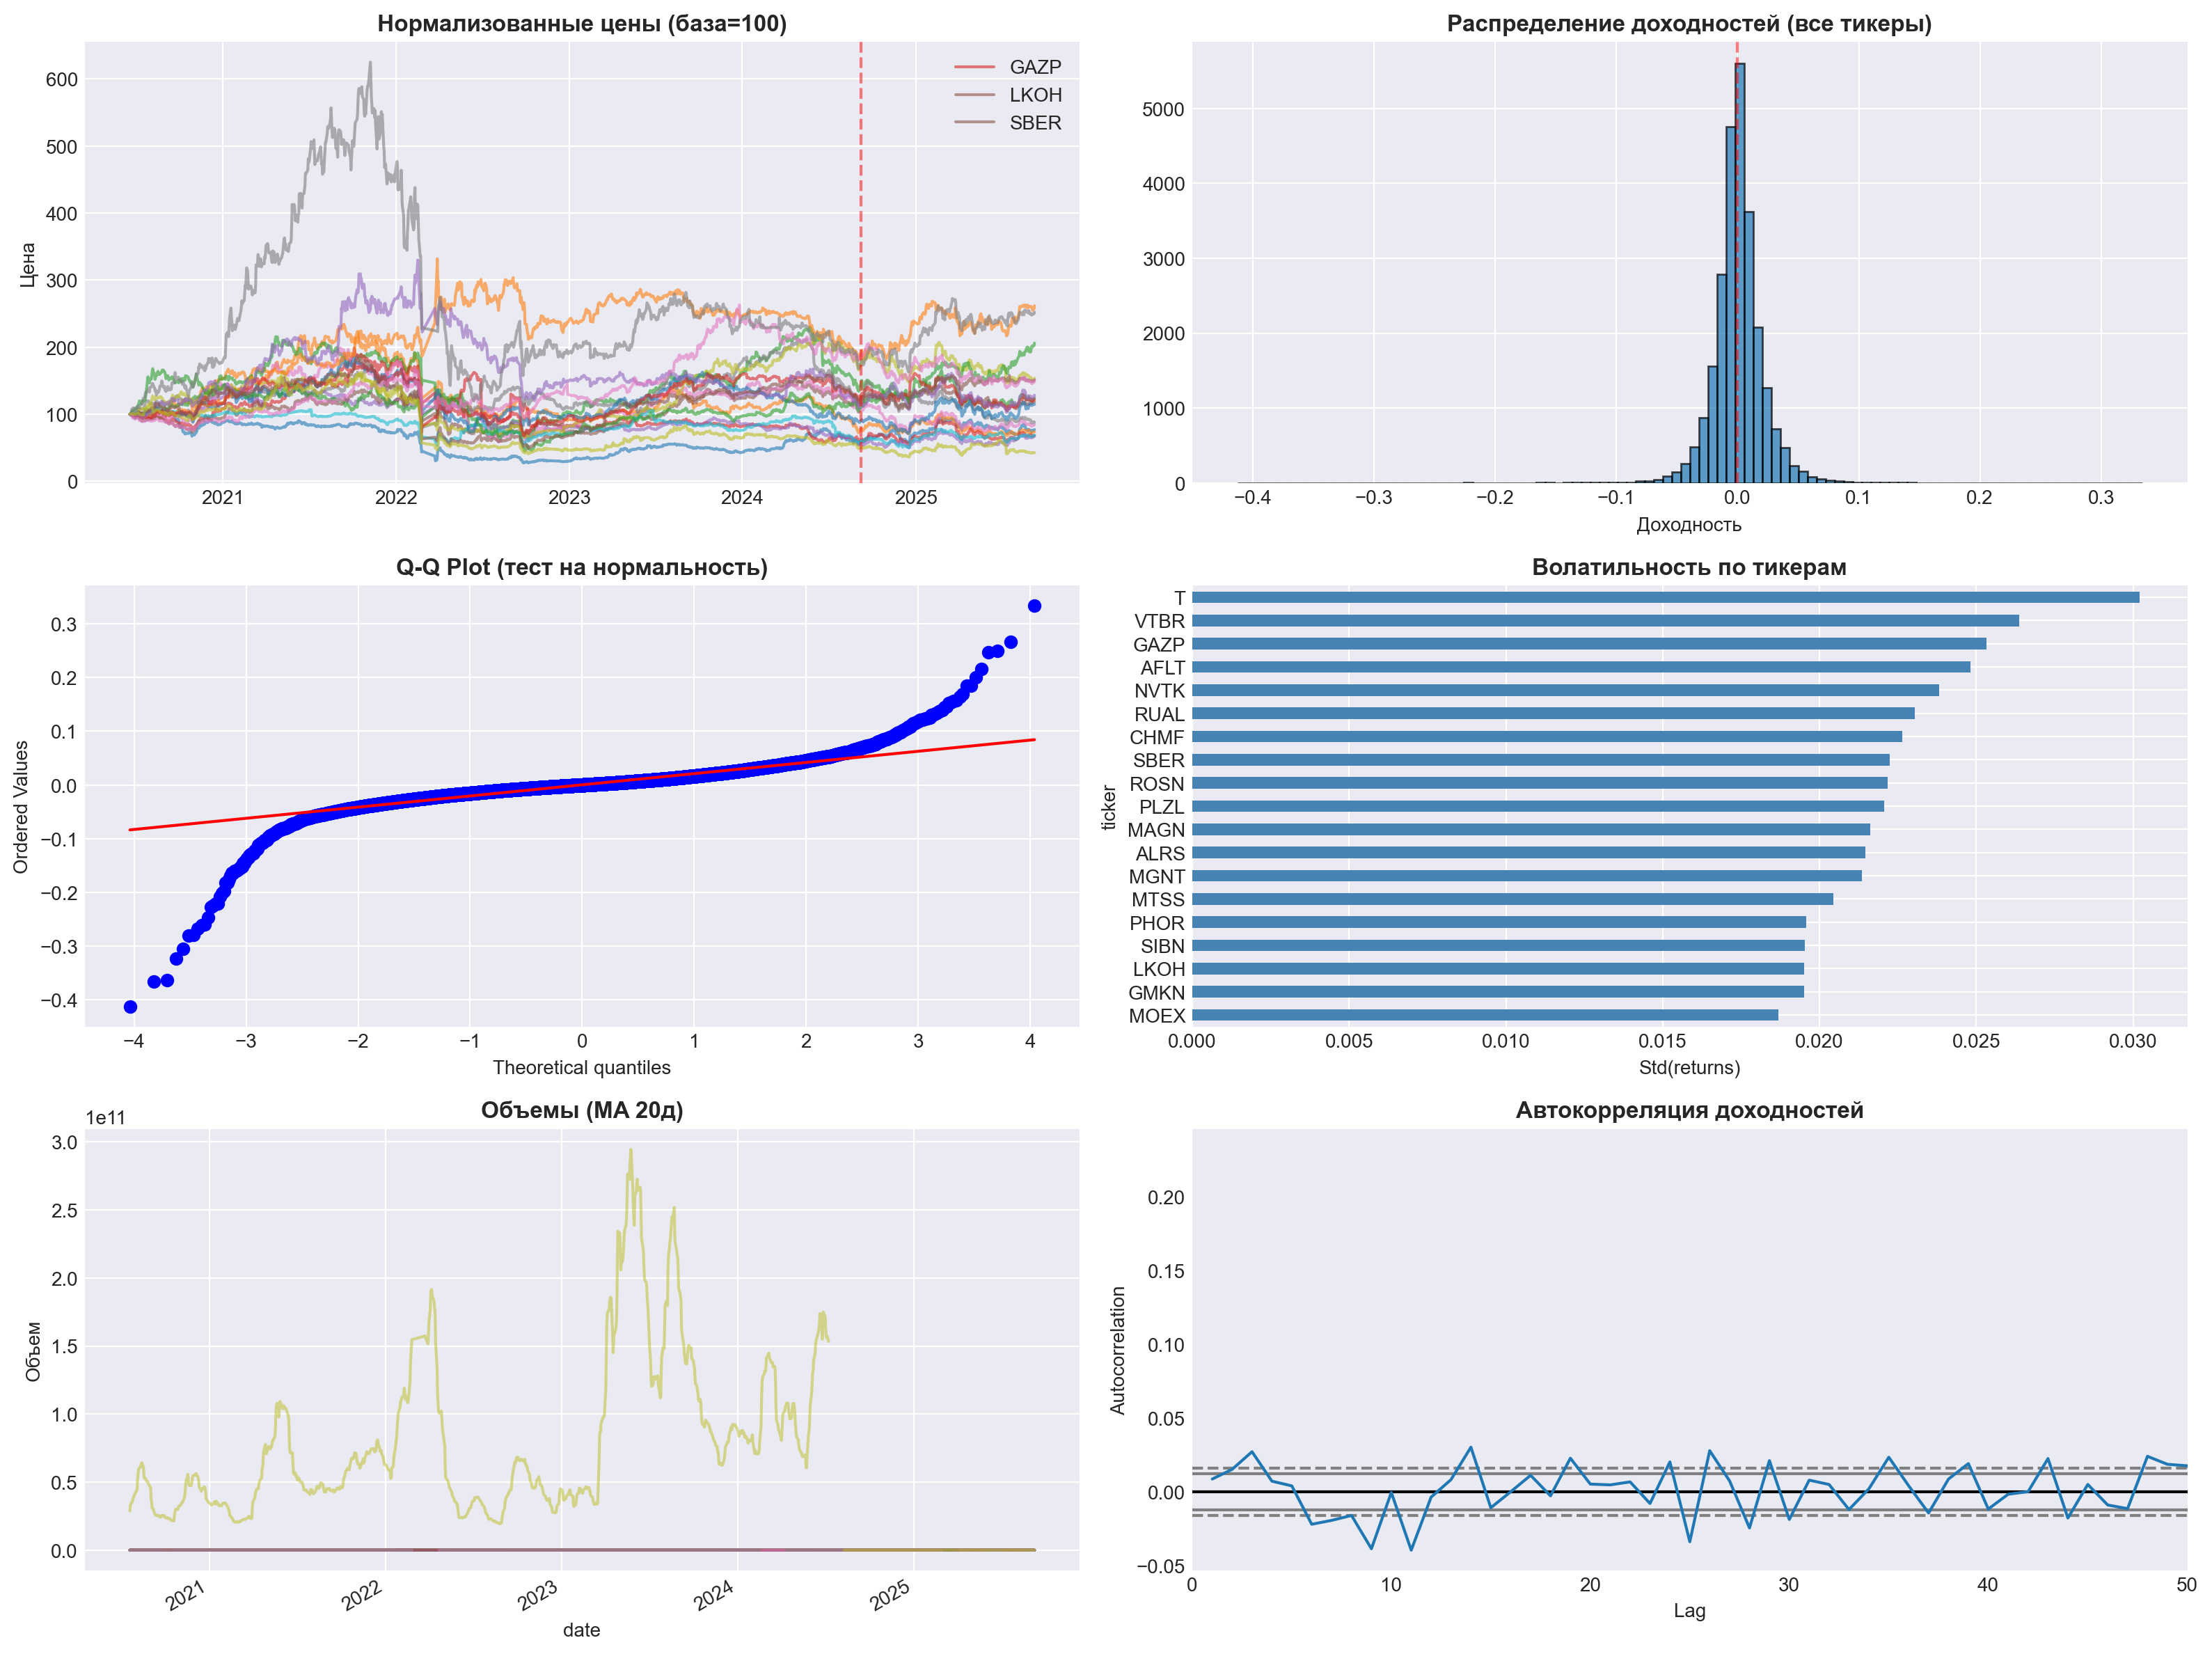


Статистика доходностей по тикерам:
          mean     std    skew  kurtosis
ticker                                  
AFLT    0.0001  0.0248 -0.6340   25.8076
ALRS    0.0000  0.0215 -0.9135   11.7416
CHMF    0.0004  0.0226 -1.2110   12.0340
GAZP    0.0000  0.0253 -1.4676   34.4919
GMKN   -0.0001  0.0195  0.1035    5.0699
LKOH    0.0003  0.0195 -0.9958   18.7960
MAGN    0.0001  0.0216 -0.3596    5.2850
MGNT    0.0001  0.0214 -1.5500   26.4784
MOEX    0.0005  0.0187 -0.8814   13.3703
MTSS   -0.0001  0.0205  1.9315   68.0779
NVTK    0.0004  0.0238 -0.3363   15.8590
PHOR    0.0009  0.0196  2.6489   34.9967
PLZL    0.0008  0.0221 -0.5651   15.7788
ROSN    0.0004  0.0222 -3.0048   59.9224
RUAL    0.0005  0.0230  0.1552    4.4600
SBER    0.0006  0.0222 -3.7045   61.1868
SIBN    0.0005  0.0195 -1.8272   29.7920
T       0.0012  0.0302 -0.4835   15.6392
VTBR   -0.0003  0.0264 -2.8645   52.1268


In [90]:
# Динамика цен
candles['returns'] = candles.groupby('ticker')['close'].pct_change()

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Нормализованные цены
for ticker in candles['ticker'].unique():
    df_t = candles[candles['ticker']==ticker].set_index('date')
    norm_price = df_t['close'] / df_t['close'].iloc[0] * 100
    axes[0,0].plot(norm_price, alpha=0.6, label=ticker if ticker in ['SBER','GAZP','LKOH'] else '')
axes[0,0].set_title('Нормализованные цены (база=100)', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('Цена')
axes[0,0].legend()
axes[0,0].axvline(pd.Timestamp('2024-09-08'), color='red', linestyle='--', alpha=0.5)

# Распределение доходностей
axes[0,1].hist(candles['returns'].dropna(), bins=100, edgecolor='black', alpha=0.7)
axes[0,1].set_title('Распределение доходностей (все тикеры)', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Доходность')
axes[0,1].axvline(0, color='red', linestyle='--', alpha=0.5)

# Q-Q plot для нормальности
stats.probplot(candles['returns'].dropna(), dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q Plot (тест на нормальность)', fontsize=12, fontweight='bold')

# Доходность по тикерам
ret_stats = candles.groupby('ticker')['returns'].agg(['mean', 'std', 'skew', lambda x: stats.kurtosis(x.dropna())])
ret_stats.columns = ['mean', 'std', 'skew', 'kurtosis']
ret_stats['std'].sort_values().plot(kind='barh', ax=axes[1,1], color='steelblue')
axes[1,1].set_title('Волатильность по тикерам', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Std(returns)')

# Динамика объемов
vol_by_ticker = candles.groupby(['date', 'ticker'])['volume'].sum().reset_index()
vol_pivot = vol_by_ticker.pivot(index='date', columns='ticker', values='volume')
vol_pivot.rolling(20).mean().plot(ax=axes[2,0], alpha=0.5, legend=False)
axes[2,0].set_title('Объемы (MA 20д)', fontsize=12, fontweight='bold')
axes[2,0].set_ylabel('Объем')

# Автокорреляция доходностей
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(candles['returns'].dropna(), ax=axes[2,1])
axes[2,1].set_title('Автокорреляция доходностей', fontsize=12, fontweight='bold')
axes[2,1].set_xlim(0, 50)

plt.tight_layout()
plt.show()

print("\nСтатистика доходностей по тикерам:")
print(ret_stats.round(4))

In [91]:
# Тест на стационарность
from statsmodels.tsa.stattools import adfuller

print("="*80)
print("ТЕСТ НА СТАЦИОНАРНОСТЬ (ADF)")
print("="*80)
print(f"{'Тикер':<10} {'Price p-val':<15} {'Returns p-val':<15} {'Стационарен?'}")
print("-"*80)

for ticker in sorted(candles['ticker'].unique()):
    df_t = candles[candles['ticker']==ticker]
    
    adf_price = adfuller(df_t['close'].dropna())
    adf_ret = adfuller(df_t['returns'].dropna())
    
    stationary = 'ДА' if adf_ret[1] < 0.05 else 'НЕТ'
    print(f"{ticker:<10} {adf_price[1]:<15.4f} {adf_ret[1]:<15.4f} {stationary}")

print("\nP-value < 0.05 означает стационарность")

ТЕСТ НА СТАЦИОНАРНОСТЬ (ADF)
Тикер      Price p-val     Returns p-val   Стационарен?
--------------------------------------------------------------------------------
AFLT       0.3307          0.0000          ДА
ALRS       0.8243          0.0000          ДА
CHMF       0.3098          0.0000          ДА
GAZP       0.4999          0.0000          ДА
GMKN       0.6808          0.0000          ДА
LKOH       0.4018          0.0000          ДА
MAGN       0.5103          0.0000          ДА
MGNT       0.3853          0.0000          ДА
MOEX       0.5690          0.0000          ДА
MTSS       0.2615          0.0000          ДА
NVTK       0.3889          0.0000          ДА
PHOR       0.2103          0.0000          ДА
PLZL       0.9292          0.0000          ДА
ROSN       0.1821          0.0000          ДА
RUAL       0.4518          0.0000          ДА
SBER       0.5953          0.0000          ДА
SIBN       0.4955          0.0000          ДА
T          0.4463          0.0000          ДА
VTBR  

Маппинг новости-тикер:
tickers
GAZP       6949
SBER       4366
GENERAL    3832
VTBR       3770
LKOH       2466
GMKN       1861
MGNT       1770
NVTK       1713
PLZL       1623
ROSN       1579
MOEX       1575
RUAL       1562
AFLT       1561
ALRS       1415
MAGN       1398
MTSS       1355
PHOR       1335
CHMF       1093
SIBN        923
T           180
Name: count, dtype: int64


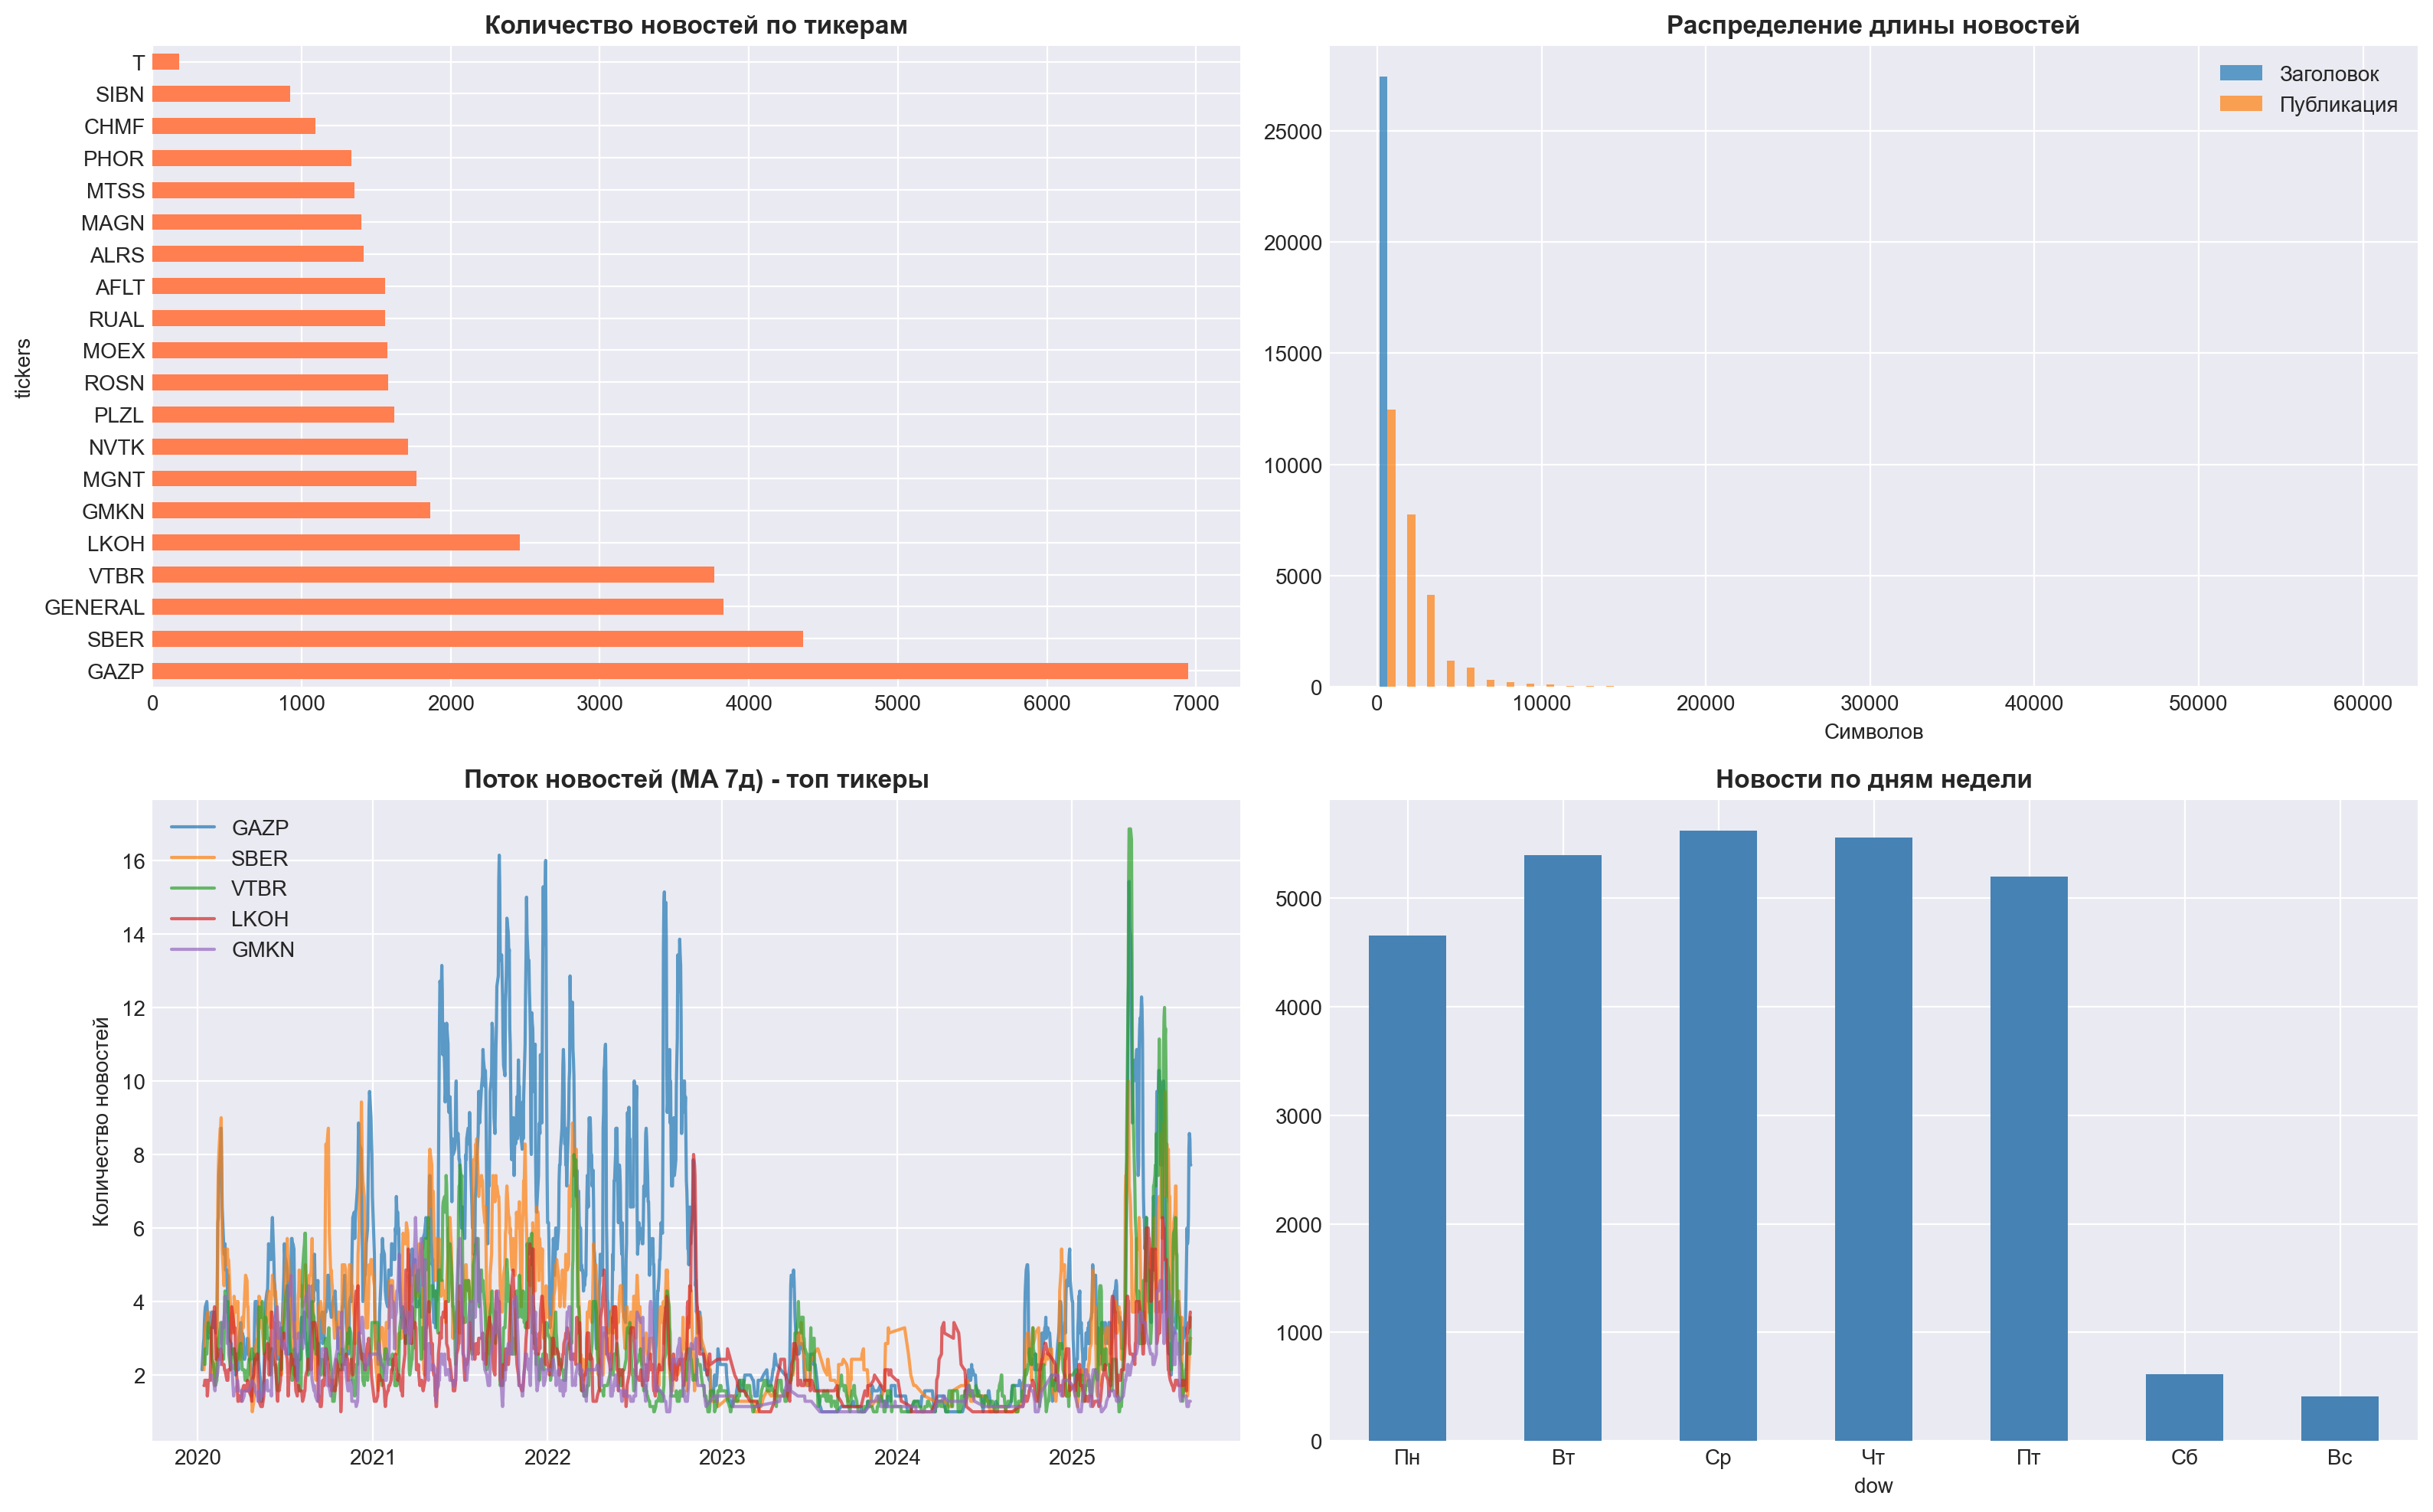

In [92]:
# Анализ новостей
ticker_keywords = {
    'AFLT': ['аэрофлот', 'aflt', 'aeroflot'],
    'ALRS': ['алроса', 'alrosa', 'alrs'],
    'CHMF': ['северсталь', 'severstal', 'chmf'],
    'GAZP': ['газпром', 'gazprom', 'gazp'],
    'GMKN': ['норникель', 'norilsk', 'gmkn', 'норильск'],
    'LKOH': ['лукойл', 'lukoil', 'lkoh'],
    'MAGN': ['ммк', 'магнитогорск', 'magn'],
    'MGNT': ['магнит', 'magnit', 'mgnt'],
    'MOEX': ['мосбиржа', 'moex', 'московская биржа'],
    'MTSS': ['мтс', 'mts', 'mtss'],
    'NVTK': ['новатэк', 'novatek', 'nvtk'],
    'PHOR': ['фосагро', 'phosagro', 'phor'],
    'PLZL': ['полюс', 'polyus', 'plzl'],
    'ROSN': ['роснефть', 'rosneft', 'rosn'],
    'RUAL': ['русал', 'rusal', 'rual'],
    'SBER': ['сбербанк', 'sberbank', 'sber', 'сбер'],
    'SIBN': ['газпром нефть', 'gazprom neft', 'sibn'],
    'T': ['тинькофф', 'tinkoff', 'тинков'],
    'VTBR': ['втб', 'vtb', 'vtbr'],
}

def find_tickers(text):
    if pd.isna(text):
        return []
    text = str(text).lower()
    found = set()
    for ticker, keywords in ticker_keywords.items():
        if any(kw in text for kw in keywords):
            found.add(ticker)
    return list(found) if found else ['GENERAL']

news['tickers'] = (news['title'].fillna('') + ' ' + news['publication'].fillna('')).apply(find_tickers)
news_exp = news.explode('tickers')

print("Маппинг новости-тикер:")
print(news_exp['tickers'].value_counts())

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Количество новостей по тикерам
news_exp['tickers'].value_counts().head(20).plot(kind='barh', ax=axes[0,0], color='coral')
axes[0,0].set_title('Количество новостей по тикерам', fontsize=12, fontweight='bold')

# Распределение длины новостей
news['title_len'] = news['title'].fillna('').str.len()
news['pub_len'] = news['publication'].fillna('').str.len()
axes[0,1].hist([news['title_len'], news['pub_len']], bins=50, label=['Заголовок', 'Публикация'], alpha=0.7)
axes[0,1].set_title('Распределение длины новостей', fontsize=12, fontweight='bold')
axes[0,1].legend()
axes[0,1].set_xlabel('Символов')

# Новости во времени для топ тикеров
top_tickers = news_exp[news_exp['tickers']!='GENERAL']['tickers'].value_counts().head(5).index
for ticker in top_tickers:
    news_ticker_data = news_exp[news_exp['tickers']==ticker]
    news_ticker = news_ticker_data.groupby(news_ticker_data['date'].dt.date).size()
    axes[1,0].plot(pd.to_datetime(news_ticker.index), news_ticker.rolling(7).mean(), label=ticker, alpha=0.7)
axes[1,0].set_title('Поток новостей (MA 7д) - топ тикеры', fontsize=12, fontweight='bold')
axes[1,0].legend()
axes[1,0].set_ylabel('Количество новостей')

# Паттерн по дням недели
news['dow'] = news['date'].dt.dayofweek
news.groupby('dow').size().plot(kind='bar', ax=axes[1,1], color='steelblue')
axes[1,1].set_title('Новости по дням недели', fontsize=12, fontweight='bold')
axes[1,1].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'], rotation=0)

plt.tight_layout()
plt.show()

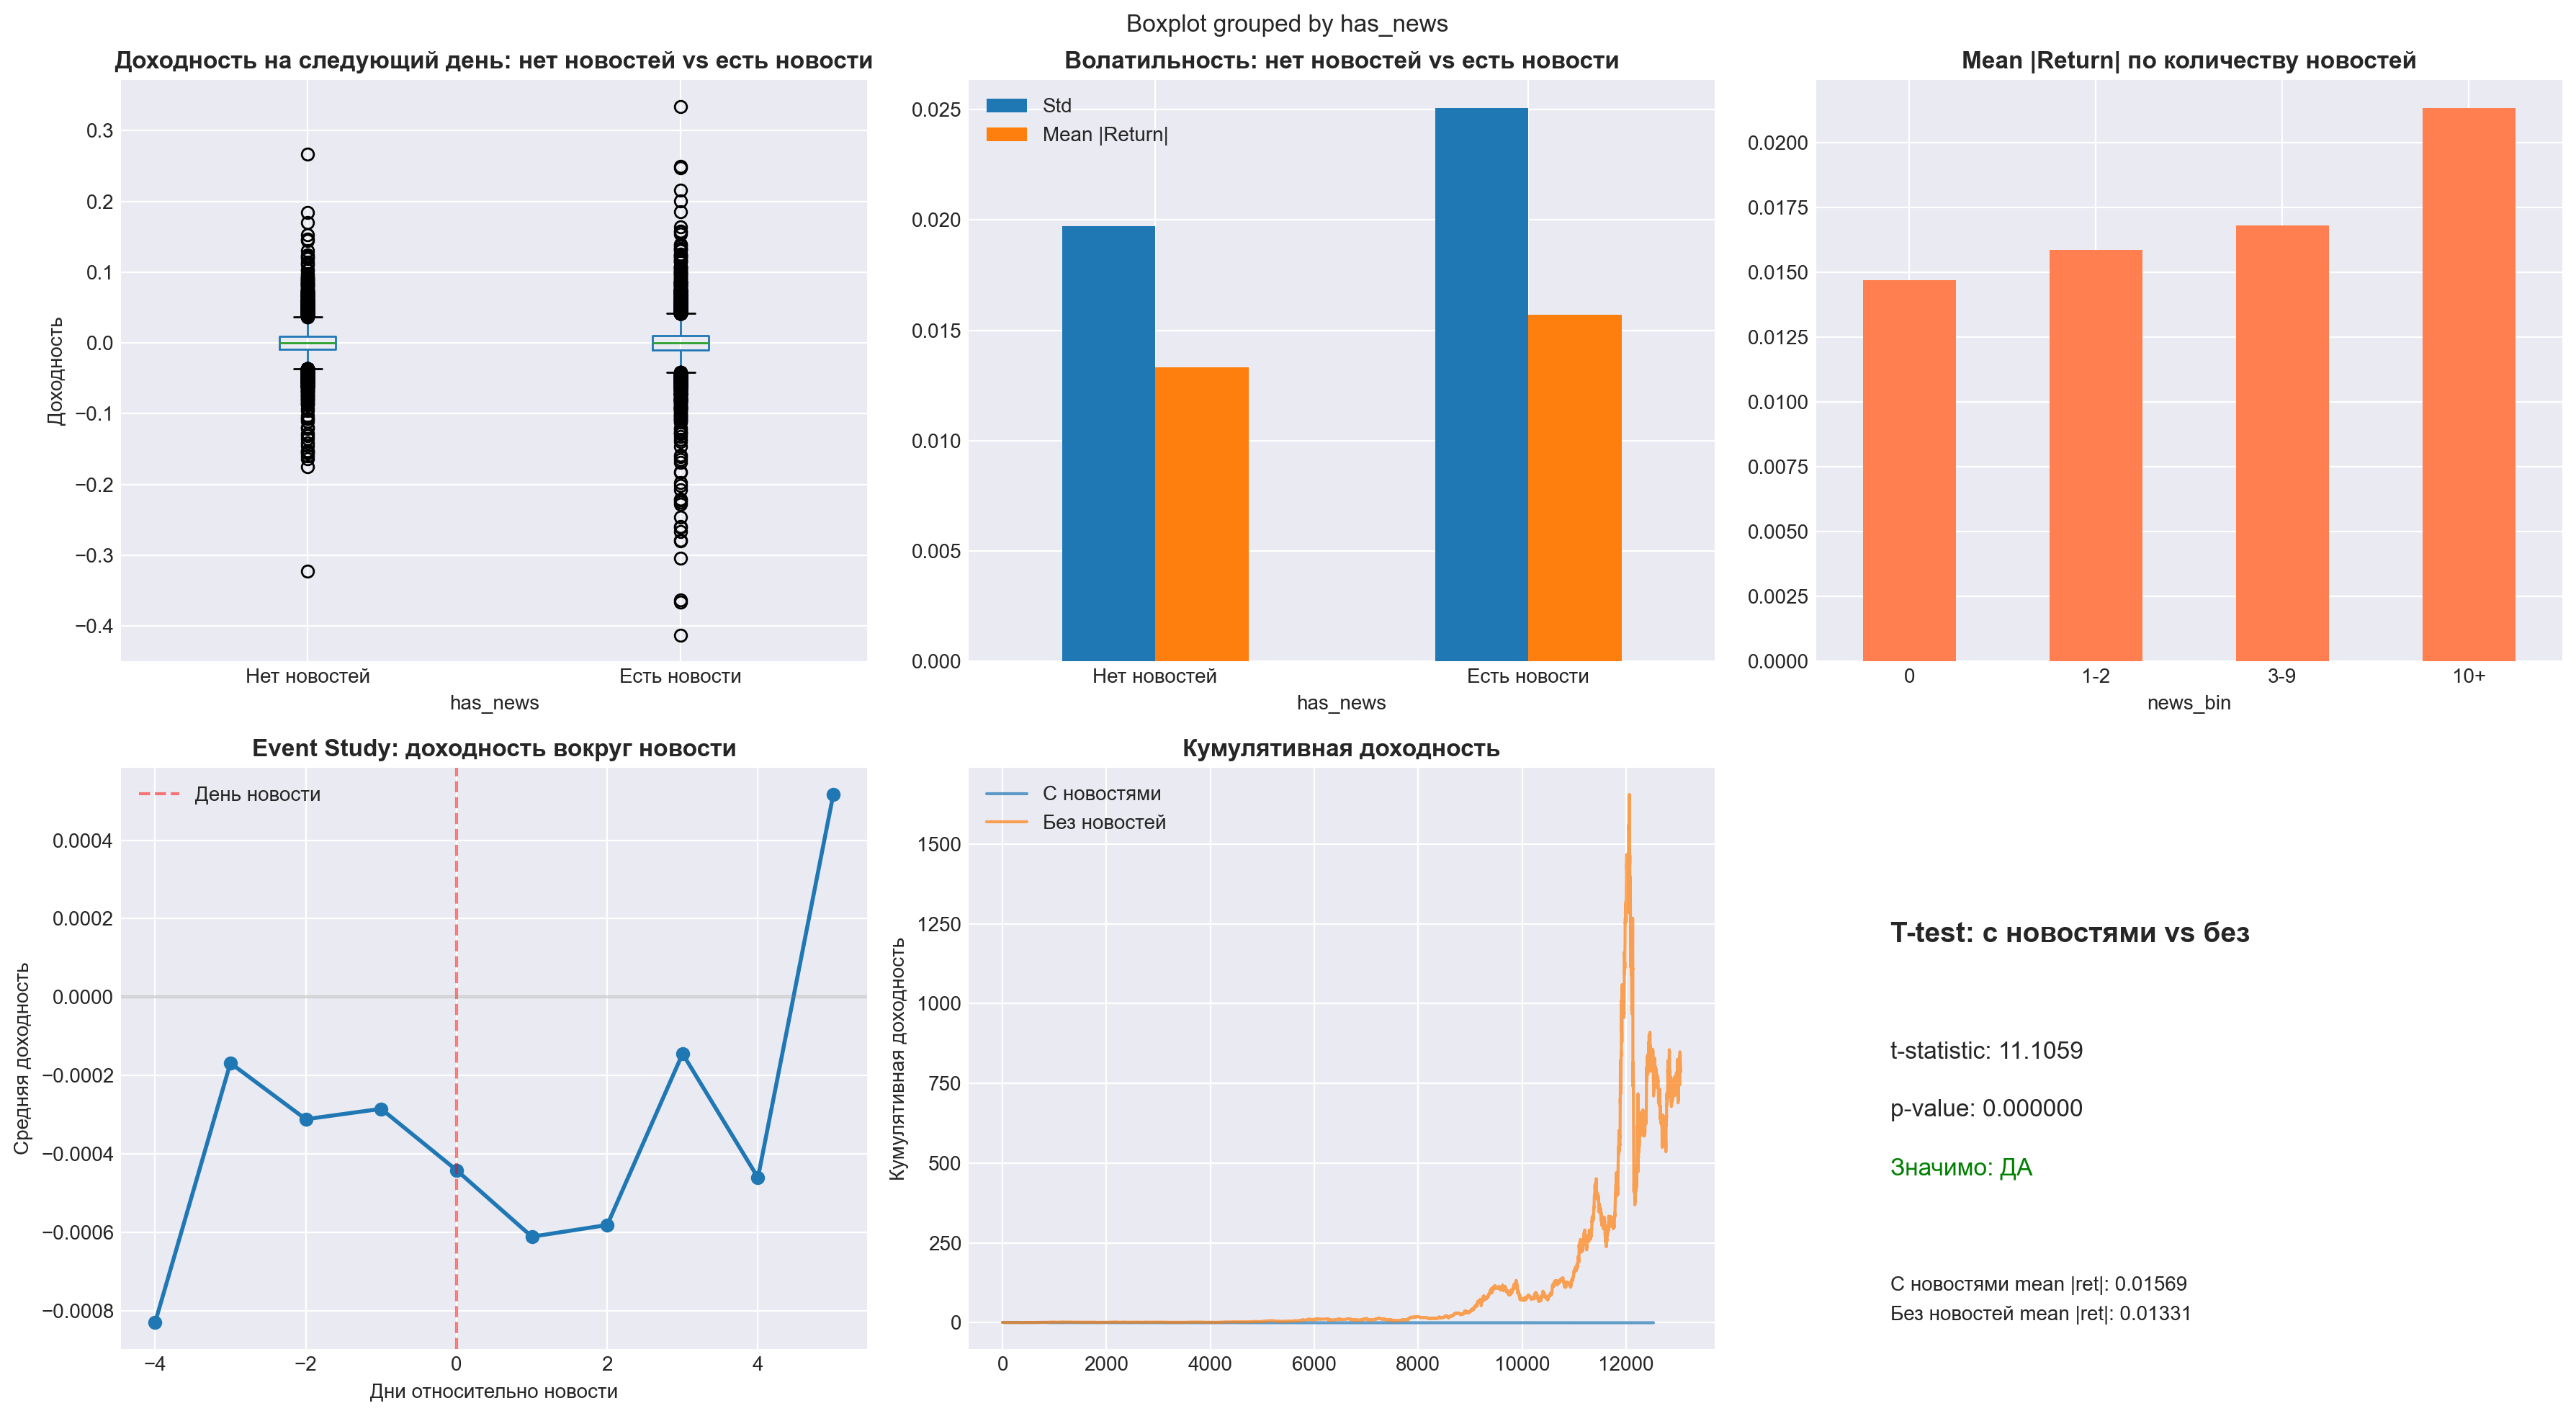


Влияние новостей:
               std      mean  abs_mean
has_news                              
0         0.019703  0.000706  0.013307
1         0.025071 -0.000049  0.015694


In [93]:
# Влияние новостей на доходность
news_exp_temp = news_exp[news_exp['tickers']!='GENERAL'].copy()
news_exp_temp['date_only'] = news_exp_temp['date'].dt.date
news_daily = news_exp_temp.groupby(['date_only', 'tickers']).size().reset_index(name='news_count')
news_daily.columns = ['date', 'ticker', 'news_count']
news_daily['date'] = pd.to_datetime(news_daily['date'])

candles_news = candles.merge(news_daily, left_on=['date', 'ticker'], right_on=['date', 'ticker'], how='left')
candles_news['news_count'] = candles_news['news_count'].fillna(0)
candles_news['has_news'] = (candles_news['news_count'] > 0).astype(int)
candles_news['next_return'] = candles_news.groupby('ticker')['returns'].shift(-1)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Доходность с новостями vs без
candles_news.boxplot(column='next_return', by='has_news', ax=axes[0,0])
axes[0,0].set_title('Доходность на следующий день: нет новостей vs есть новости', fontsize=12, fontweight='bold')
axes[0,0].set_xticklabels(['Нет новостей', 'Есть новости'])
axes[0,0].set_ylabel('Доходность')

# Волатильность
vol_comparison = candles_news.groupby('has_news')['next_return'].agg(['std', 'mean', lambda x: x.abs().mean()])
vol_comparison.columns = ['std', 'mean', 'abs_mean']
vol_comparison[['std', 'abs_mean']].plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Волатильность: нет новостей vs есть новости', fontsize=12, fontweight='bold')
axes[0,1].set_xticklabels(['Нет новостей', 'Есть новости'], rotation=0)
axes[0,1].legend(['Std', 'Mean |Return|'])

# Бины по количеству новостей
candles_news['news_bin'] = pd.cut(candles_news['news_count'], bins=[0, 1, 3, 10, 100], labels=['0', '1-2', '3-9', '10+'])
candles_news.groupby('news_bin')['next_return'].apply(lambda x: x.abs().mean()).plot(kind='bar', ax=axes[0,2], color='coral')
axes[0,2].set_title('Mean |Return| по количеству новостей', fontsize=12, fontweight='bold')
axes[0,2].set_xticklabels(axes[0,2].get_xticklabels(), rotation=0)

# Event study
news_events = candles_news[candles_news['has_news']==1][['ticker', 'date']]
event_returns = []
for _, row in news_events.head(1000).iterrows():
    ticker_data = candles_news[(candles_news['ticker']==row['ticker'])].set_index('date')
    event_idx = ticker_data.index.get_loc(row['date'])
    if event_idx >= 5 and event_idx < len(ticker_data) - 5:
        event_window = ticker_data['returns'].iloc[event_idx-5:event_idx+6].values
        event_returns.append(event_window)

event_returns = np.array(event_returns)
mean_returns = event_returns.mean(axis=0)
axes[1,0].plot(range(-5, 6), mean_returns, marker='o', linewidth=2)
axes[1,0].axvline(0, color='red', linestyle='--', alpha=0.5, label='День новости')
axes[1,0].axhline(0, color='gray', linestyle='-', alpha=0.3)
axes[1,0].set_title('Event Study: доходность вокруг новости', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Дни относительно новости')
axes[1,0].set_ylabel('Средняя доходность')
axes[1,0].legend()

# Кумулятивная доходность
cum_news = (1 + candles_news[candles_news['has_news']==1]['next_return'].dropna()).cumprod()
cum_no_news = (1 + candles_news[candles_news['has_news']==0]['next_return'].dropna()).cumprod()
axes[1,1].plot(cum_news.values, label='С новостями', alpha=0.7)
axes[1,1].plot(cum_no_news.values, label='Без новостей', alpha=0.7)
axes[1,1].set_title('Кумулятивная доходность', fontsize=12, fontweight='bold')
axes[1,1].legend()
axes[1,1].set_ylabel('Кумулятивная доходность')

# Статистический тест
news_rets = candles_news[candles_news['has_news']==1]['next_return'].dropna()
no_news_rets = candles_news[candles_news['has_news']==0]['next_return'].dropna()
t_stat, p_val = stats.ttest_ind(news_rets.abs(), no_news_rets.abs())

axes[1,2].text(0.1, 0.7, f"T-test: с новостями vs без", fontsize=14, fontweight='bold')
axes[1,2].text(0.1, 0.5, f"t-statistic: {t_stat:.4f}", fontsize=12)
axes[1,2].text(0.1, 0.4, f"p-value: {p_val:.6f}", fontsize=12)
axes[1,2].text(0.1, 0.3, f"Значимо: {'ДА' if p_val < 0.05 else 'НЕТ'}", fontsize=12, 
               color='green' if p_val < 0.05 else 'red')
axes[1,2].text(0.1, 0.1, f"С новостями mean |ret|: {news_rets.abs().mean():.5f}", fontsize=10)
axes[1,2].text(0.1, 0.05, f"Без новостей mean |ret|: {no_news_rets.abs().mean():.5f}", fontsize=10)
axes[1,2].axis('off')

plt.tight_layout()
plt.show()

print("\nВлияние новостей:")
print(vol_comparison)

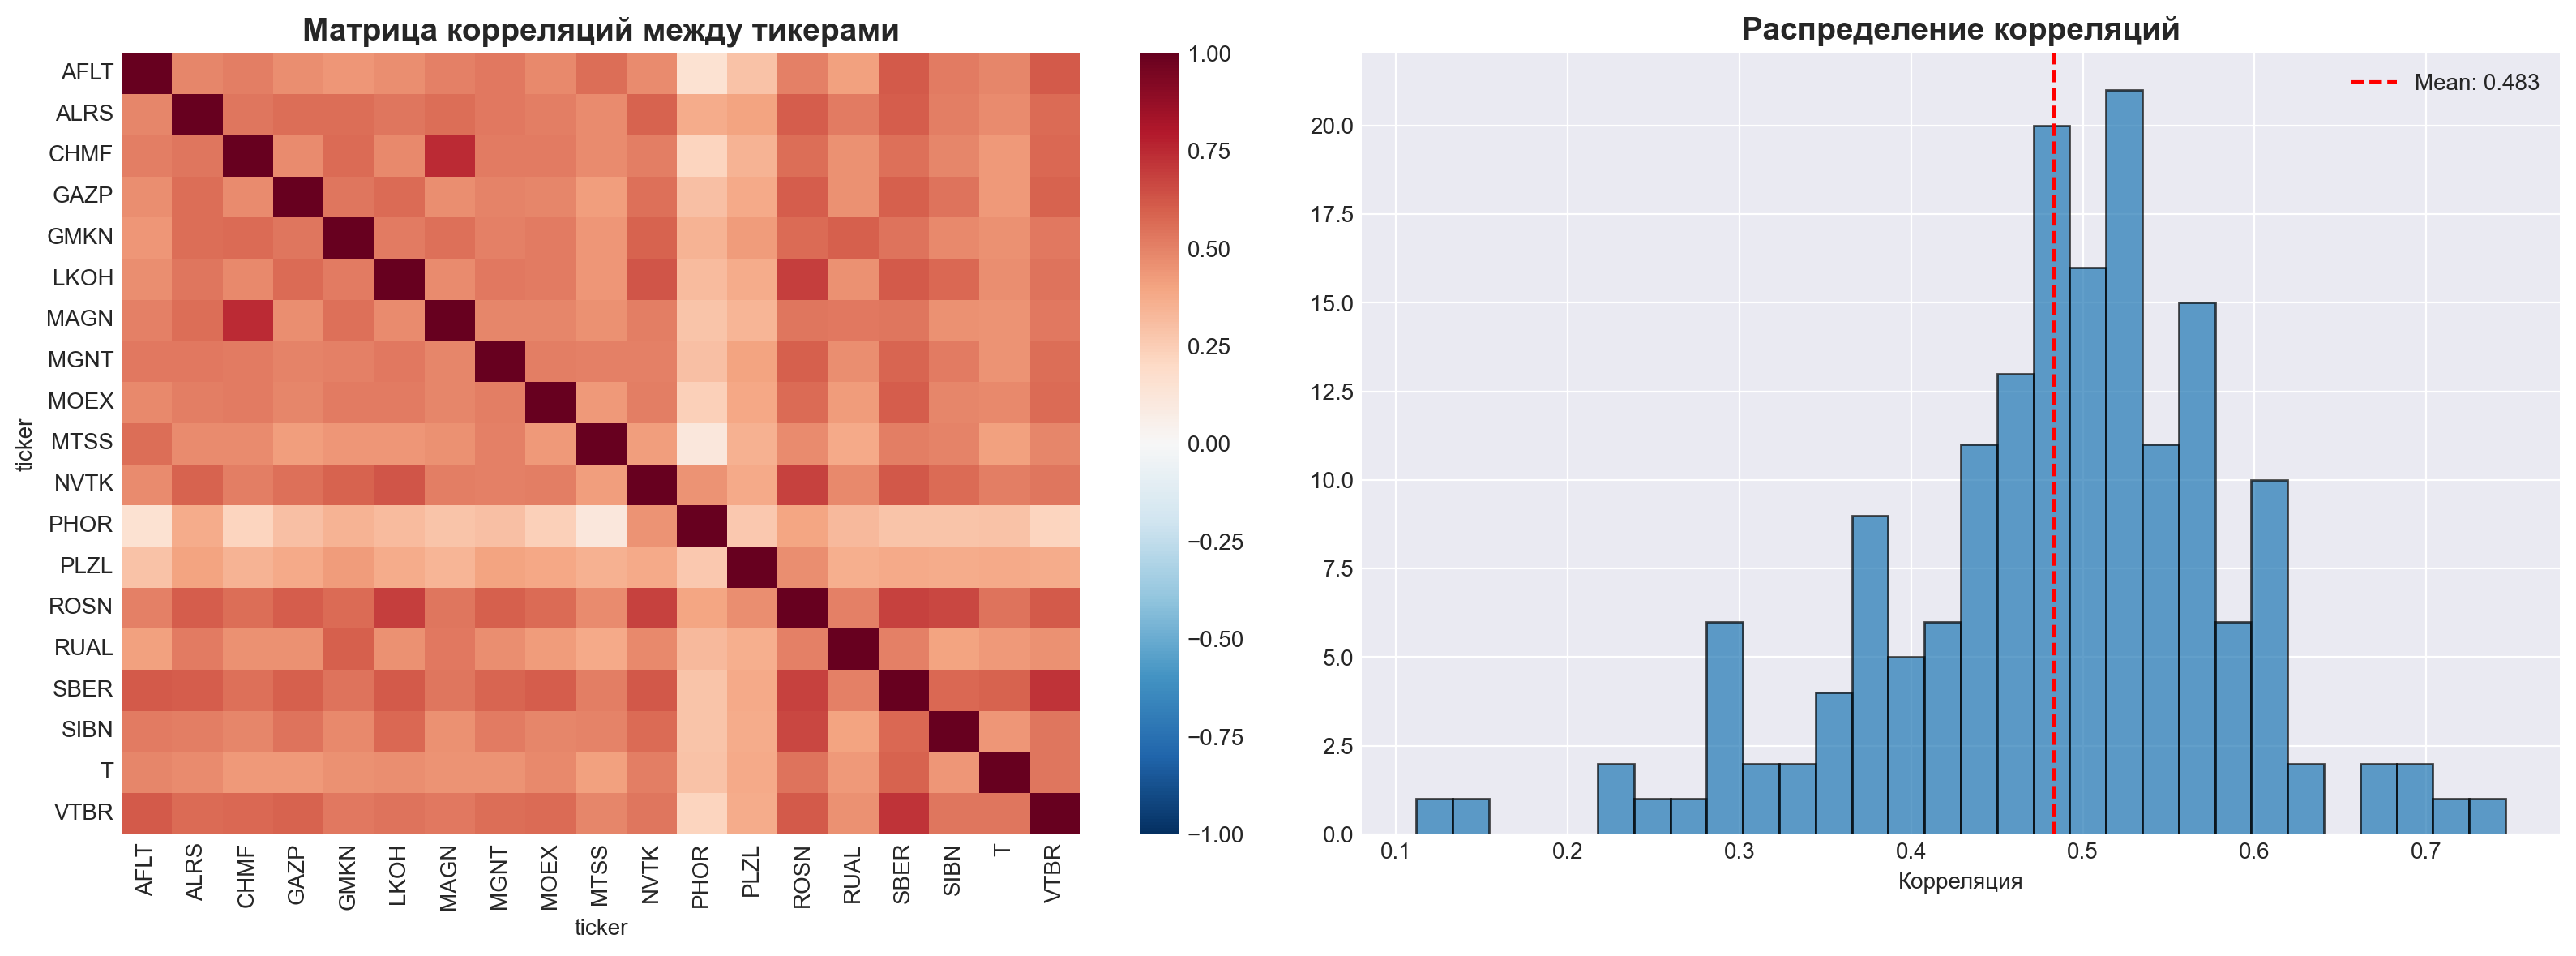

Средняя корреляция: 0.4832
Медианная корреляция: 0.4943
Std корреляции: 0.1031


In [94]:
# Корреляционный анализ
returns_pivot = candles.pivot(index='date', columns='ticker', values='returns')
corr_matrix = returns_pivot.corr()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(corr_matrix, annot=False, cmap='RdBu_r', center=0, ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title('Матрица корреляций между тикерами', fontsize=14, fontweight='bold')

corr_values = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
axes[1].hist(corr_values, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(corr_values.mean(), color='red', linestyle='--', label=f'Mean: {corr_values.mean():.3f}')
axes[1].set_title('Распределение корреляций', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Корреляция')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Средняя корреляция: {corr_values.mean():.4f}")
print(f"Медианная корреляция: {np.median(corr_values):.4f}")
print(f"Std корреляции: {corr_values.std():.4f}")

# 🎯 CV и подготовка данных

**Стратегия**:
- Темпоральная валидация (3 фолда rolling window)
- Ticker holdout для симуляции новых акций (On scenario)
- Train cutoff: 2024-09-08

**Важно**: Строгое соблюдение временных границ для предотвращения утечек

In [95]:
# CV стратегия
TRAIN_CUTOFF = pd.Timestamp('2024-09-08')

# Темпоральные фолды (rolling window)
cv_splits = [
    {'name': 'fold1', 'train_end': '2024-06-01', 'val_start': '2024-06-01', 'val_end': '2024-07-01'},
    {'name': 'fold2', 'train_end': '2024-07-01', 'val_start': '2024-07-01', 'val_end': '2024-08-01'},
    {'name': 'fold3', 'train_end': '2024-08-01', 'val_start': '2024-08-01', 'val_end': '2024-09-08'},
]
cv_splits = [{**s, 'train_end': pd.Timestamp(s['train_end']), 
              'val_start': pd.Timestamp(s['val_start']), 
              'val_end': pd.Timestamp(s['val_end'])} for s in cv_splits]

# Holdout тикеров для симуляции On
np.random.seed(42)
all_tickers = sorted(candles['ticker'].unique())
holdout_tickers = np.random.choice(all_tickers, size=4, replace=False).tolist()
train_tickers = [t for t in all_tickers if t not in holdout_tickers]

print("="*80)
print("CV СТРАТЕГИЯ")
print("="*80)
print(f"Все тикеры ({len(all_tickers)}): {all_tickers}")
print(f"\nHoldout тикеры ({len(holdout_tickers)}) - симуляция On: {holdout_tickers}")
print(f"Train тикеры ({len(train_tickers)}): {train_tickers}")
print(f"\nТемпоральные CV фолды:")
for split in cv_splits:
    train_size = len(candles[(candles['date'] < split['train_end']) & (candles['ticker'].isin(train_tickers))])
    val_size = len(candles[(candles['date'] >= split['val_start']) & (candles['date'] < split['val_end']) & (candles['ticker'].isin(train_tickers))])
    print(f"  {split['name']}: train до {split['train_end'].date()} (n={train_size}), val {split['val_start'].date()}-{split['val_end'].date()} (n={val_size})")
    
post_cutoff_size = len(candles[candles['date'] > TRAIN_CUTOFF])
print(f"\nПост-катофф валидация: после {TRAIN_CUTOFF.date()} (n={post_cutoff_size})")
print(f"Holdout тикеры валидация: {len(candles[candles['ticker'].isin(holdout_tickers)])} сэмплов")

CV СТРАТЕГИЯ
Все тикеры (19): ['AFLT', 'ALRS', 'CHMF', 'GAZP', 'GMKN', 'LKOH', 'MAGN', 'MGNT', 'MOEX', 'MTSS', 'NVTK', 'PHOR', 'PLZL', 'ROSN', 'RUAL', 'SBER', 'SIBN', 'T', 'VTBR']

Holdout тикеры (4) - симуляция On: ['AFLT', 'LKOH', 'PHOR', 'ALRS']
Train тикеры (15): ['CHMF', 'GAZP', 'GMKN', 'MAGN', 'MGNT', 'MOEX', 'MTSS', 'NVTK', 'PLZL', 'ROSN', 'RUAL', 'SBER', 'SIBN', 'T', 'VTBR']

Темпоральные CV фолды:
  fold1: train до 2024-06-01 (n=14728), val 2024-06-01-2024-07-01 (n=285)
  fold2: train до 2024-07-01 (n=15013), val 2024-07-01-2024-08-01 (n=341)
  fold3: train до 2024-08-01 (n=15354), val 2024-08-01-2024-09-08 (n=405)

Пост-катофф валидация: после 2024-09-08 (n=5631)
Holdout тикеры валидация: 5398 сэмплов


In [96]:
# Фичи
def create_features(df, news_df=None):
    df = df.copy().sort_values(['ticker', 'date']).reset_index(drop=True)
    
    # Возвраты на разных горизонтах
    df['returns'] = df.groupby('ticker')['close'].pct_change()
    for horizon in [1, 2, 5, 10, 20, 60]:
        df[f'return_{horizon}d'] = df.groupby('ticker')['close'].pct_change(horizon)
        df[f'log_return_{horizon}d'] = np.log(df.groupby('ticker')['close'].shift(-horizon) / df['close'])
    
    # Волатильность
    for window in [5, 10, 20, 60]:
        df[f'realized_vol_{window}d'] = df.groupby('ticker')['returns'].transform(
            lambda x: x.rolling(window, min_periods=1).std()
        )
    
    df['hl_spread'] = (df['high'] - df['low']) / df['close']
    for window in [20]:
        df[f'hl_vol_{window}d'] = df.groupby('ticker')['hl_spread'].transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        )
        df[f'parkinson_vol_{window}d'] = df.groupby('ticker').apply(
            lambda x: np.sqrt(1/(4*np.log(2)) * (np.log(x['high']/x['low'])**2).rolling(window, min_periods=1).mean())
        ).reset_index(level=0, drop=True)
    
    df['vol_ratio_5_20'] = df['realized_vol_5d'] / (df['realized_vol_20d'] + 1e-8)
    df['vol_ratio_10_60'] = df['realized_vol_10d'] / (df['realized_vol_60d'] + 1e-8)
    
    # Моментум и mean reversion
    for window in [5, 10, 20, 60]:
        df[f'sma_{window}'] = df.groupby('ticker')['close'].transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        )
    
    for window in [5, 20, 60]:
        df[f'price_to_sma_{window}'] = df['close'] / (df[f'sma_{window}'] + 1e-8) - 1
    
    df['momentum_5_20'] = (df['sma_5'] / (df['sma_20'] + 1e-8)) - 1
    df['momentum_10_60'] = (df['sma_10'] / (df['sma_60'] + 1e-8)) - 1
    
    # RSI
    def compute_rsi(series, period):
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period, min_periods=1).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period, min_periods=1).mean()
        rs = gain / (loss + 1e-8)
        return 100 - (100 / (1 + rs))
    
    df['rsi_14'] = df.groupby('ticker')['close'].transform(lambda x: compute_rsi(x, 14))
    df['rsi_30'] = df.groupby('ticker')['close'].transform(lambda x: compute_rsi(x, 30))
    
    # Объемы
    for window in [5, 20]:
        df[f'volume_ma_{window}'] = df.groupby('ticker')['volume'].transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        )
        df[f'volume_std_{window}'] = df.groupby('ticker')['volume'].transform(
            lambda x: x.rolling(window, min_periods=1).std()
        )
    
    df['volume_rel'] = df['volume'] / (df['volume_ma_20'] + 1e-8)
    df['volume_zscore'] = (df['volume'] - df['volume_ma_20']) / (df['volume_std_20'] + 1e-8)
    
    df['vol_price_corr_20'] = df.groupby('ticker').apply(
        lambda x: x['volume'].rolling(20, min_periods=1).corr(x['returns'].abs())
    ).reset_index(level=0, drop=True)
    
    # Маркет-уровневые фичи (критично для On)
    market_agg = df.groupby('date').agg({
        'returns': ['mean', 'std', 'median'],
        'realized_vol_20d': ['mean', 'std'],
        'volume_rel': ['mean']
    })
    market_agg.columns = ['_'.join(col).strip() for col in market_agg.columns.values]
    market_agg = market_agg.add_prefix('market_')
    df = df.merge(market_agg, left_on='date', right_index=True, how='left')
    
    # Cross-sectional ранги
    df['return_rank'] = df.groupby('date')['returns'].rank(pct=True)
    df['volume_rank'] = df.groupby('date')['volume_rel'].rank(pct=True)
    df['vol_rank'] = df.groupby('date')['realized_vol_20d'].rank(pct=True)
    
    # Beta
    df['beta_20'] = df.groupby('ticker').apply(
        lambda x: x['returns'].rolling(20, min_periods=1).corr(x['market_returns_mean'])
    ).reset_index(level=0, drop=True)
    df['beta_60'] = df.groupby('ticker').apply(
        lambda x: x['returns'].rolling(60, min_periods=1).corr(x['market_returns_mean'])
    ).reset_index(level=0, drop=True)
    
    df['return_vs_market'] = df['returns'] - df['market_returns_mean']
    df['vol_vs_market'] = df['realized_vol_20d'] - df['market_realized_vol_20d_mean']
    
    # Временные фичи
    df['dow'] = df['date'].dt.dayofweek
    df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 5)
    df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 5)
    df['day_of_month'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    
    df['days_since_max_20'] = df.groupby('ticker')['close'].transform(
        lambda x: x.rolling(20, min_periods=1).apply(lambda y: 20 - y.argmax() - 1 if len(y) > 0 else 0)
    )
    df['days_since_min_20'] = df.groupby('ticker')['close'].transform(
        lambda x: x.rolling(20, min_periods=1).apply(lambda y: 20 - y.argmin() - 1 if len(y) > 0 else 0)
    )
    
    # Лаги
    for lag in [1, 2, 5]:
        df[f'return_1d_lag{lag}'] = df.groupby('ticker')['returns'].shift(lag)
        df[f'realized_vol_20d_lag{lag}'] = df.groupby('ticker')['realized_vol_20d'].shift(lag)
    
    # Новости
    if news_df is not None:
        news_agg = news_df.groupby([news_df['date'].dt.date, 'ticker']).size().reset_index(name='news_count')
        news_agg['date'] = pd.to_datetime(news_agg['date'])
        news_agg['date'] = news_agg['date'] + pd.Timedelta(days=1)  # сдвиг на +1 день
        df = df.merge(news_agg, on=['date', 'ticker'], how='left')
        df['news_count'] = df['news_count'].fillna(0)
        
        for window in [3, 7, 14]:
            df[f'news_{window}d'] = df.groupby('ticker')['news_count'].transform(
                lambda x: x.rolling(window, min_periods=1).sum()
            )
    
    # Таргеты
    df['target_1d'] = (df.groupby('ticker')['close'].shift(-1) - df['close']) / df['close']
    df['target_20d'] = (df.groupby('ticker')['close'].shift(-20) - df['close']) / df['close']
    
    return df

news_ticker_ready = news_exp[news_exp['tickers']!='GENERAL'][['date', 'tickers']].rename(columns={'tickers': 'ticker'})

print("Создание фич...")
candles_feat = create_features(candles, news_ticker_ready)

print(f"\nРазмер матрицы фич: {candles_feat.shape}")
n_features = len([c for c in candles_feat.columns if c not in ['open','high','low','close','volume','begin','ticker','date','target_1d','target_20d']])
print(f"Всего фич: {n_features}")

Создание фич...

Размер матрицы фич: (25602, 80)
Всего фич: 70


# 📰 News Feature Engineering 

In [97]:
# Этап 1: Простой keyword-based sentiment analysis
import pandas as pd
import numpy as np
import re

# Путь для кэша
CACHE_PATH = './news_df_with_sentiment.pkl'

# Проверяем наличие кэша
import os.path
if os.path.exists(CACHE_PATH):
    print("✓ Найден кэш! Загрузка news_df из файла...")
    news_df = pd.read_pickle(CACHE_PATH)
    print(f"Загружено {len(news_df)} новостей с sentiment")
    print(f"Средний sentiment: {news_df['sentiment'].mean():.3f}")
    print(f"Std sentiment: {news_df['sentiment'].std():.3f}")
else:
    print("Кэш не найден, запускаем keyword-based sentiment analysis...")
    
    # Словари ключевых слов для русского финансового контекста
    positive_keywords = [
        'рост', 'прибыль', 'увеличени', 'развити', 'успех', 'позитив', 
        'укрепл', 'повыш', 'подъ', 'восстановл', 'улучш', 'достиж',
        'прорыв', 'эффективн', 'оптимизац', 'инновац', 'модерниз',
        'расширен', 'диверсифик', 'стабилизац', 'рекорд', 'максимум',
        'дивиденд', 'выручк', 'рентабельн', 'капитализац'
    ]
    
    negative_keywords = [
        'падени', 'убыт', 'снижени', 'кризис', 'риск', 'угроз',
        'дефолт', 'банкротств', 'спад', 'потер', 'сокращ', 'упад',
        'провал', 'неудач', 'проблем', 'задолженн', 'санкци',
        'штраф', 'скандал', 'коррупц', 'арест', 'минимум', 'обвал',
        'девальвац', 'инфляц', 'рецесс', 'стагнац'
    ]
    
    def calculate_sentiment(text):
        """
        Простой sentiment analyzer на базе ключевых слов
        Возвращает значение от -1 (негатив) до +1 (позитив)
        """
        if pd.isna(text):
            return 0.0
        
        text_lower = str(text).lower()
        
        # Подсчет позитивных и негативных слов
        pos_count = sum(1 for keyword in positive_keywords if keyword in text_lower)
        neg_count = sum(1 for keyword in negative_keywords if keyword in text_lower)
        
        # Если нет ни одного ключевого слова - нейтральный sentiment
        total_keywords = pos_count + neg_count
        if total_keywords == 0:
            return 0.0
        
        # Нормализуем в диапазон [-1, 1]
        sentiment = (pos_count - neg_count) / total_keywords
        
        # Усиление сигнала (делаем sentiment более выраженным)
        # Применяем tanh для ограничения в [-1, 1]
        sentiment = np.tanh(sentiment * 1.5)
        
        return sentiment
    
    # Обработка новостей
    print("Обработка новостей с keyword-based sentiment...")
    news_df = news.copy()
    
    # Комбинируем заголовок и текст публикации
    news_df['full_text'] = news_df['title'].fillna('').astype(str) + ' ' + news_df['publication'].fillna('').astype(str)
    
    # Получаем sentiment scores (быстро!)
    try:
        from tqdm import tqdm
        tqdm.pandas()
        news_df['sentiment'] = news_df['full_text'].progress_apply(calculate_sentiment)
    except ImportError:
        news_df['sentiment'] = news_df['full_text'].apply(calculate_sentiment)
    
    print(f"\nОбработано {len(news_df)} новостей")
    print(f"Средний sentiment: {news_df['sentiment'].mean():.3f}")
    print(f"Std sentiment: {news_df['sentiment'].std():.3f}")
    print(f"\nРаспределение sentiment:")
    print(news_df['sentiment'].describe())
    
    # Сохраняем в кэш
    print(f"\n💾 Сохранение в кэш: {CACHE_PATH}")
    news_df.to_pickle(CACHE_PATH)
    print("✓ Кэш сохранен")

# Показываем примеры sentiment для проверки
print("\n📊 Примеры новостей с sentiment:")
sample_news = news_df.nlargest(3, 'sentiment')[['title', 'sentiment']]
print("\nТоп-3 позитивных:")
for idx, row in sample_news.iterrows():
    print(f"  {row['sentiment']:.3f}: {row['title'][:80]}")

sample_news = news_df.nsmallest(3, 'sentiment')[['title', 'sentiment']]
print("\nТоп-3 негативных:")
for idx, row in sample_news.iterrows():
    print(f"  {row['sentiment']:.3f}: {row['title'][:80]}")


Кэш не найден, запускаем keyword-based sentiment analysis...
Обработка новостей с keyword-based sentiment...


100%|██████████| 27455/27455 [00:01<00:00, 16860.99it/s]



Обработано 27455 новостей
Средний sentiment: 0.292
Std sentiment: 0.509

Распределение sentiment:
count    27455.000000
mean         0.291627
std          0.508697
min         -0.905148
25%          0.000000
50%          0.244919
75%          0.905148
max          0.905148
Name: sentiment, dtype: float64

💾 Сохранение в кэш: ./news_df_with_sentiment.pkl
✓ Кэш сохранен

📊 Примеры новостей с sentiment:

Топ-3 позитивных:
  0.905: ПАО "ММК" -  "Выплата дивидендов в виде денежных средств"
  0.905: ПАО "МТС" - "Выплата дивидендов в виде денежных средств"
  0.905: Целевой ориентир по акциям "Сбербанка" - 290 рублей

Топ-3 негативных:
  -0.905: Правительство РФ утвердило прогнозный план приватизации на 3 года
  -0.905: Акции "ЛУКОЙЛа" могут скорректироваться
  -0.905: Пожар на нефтезаводе "ЛУКОЙЛа" в Ухте потушен


In [98]:
# Этап 2: Market-level агрегация (не ticker-specific!)
import pandas as pd
import numpy as np

print("\nСоздание market-level новостных фич...")

# Конвертируем даты (оставляем как datetime64[ns], НЕ конвертируем в .dt.date)
news_df['date'] = pd.to_datetime(news_df['publish_date'])

# Получаем unique даты из candles (не candles_feat, он еще не создан)
candles_dates = pd.to_datetime(candles['begin'])
unique_dates = sorted(candles_dates.unique())

# Создаем временные окна для агрегации
windows = [1, 3, 7, 14, 30]

def create_news_features(row_date):
    """Создает market-level фичи для конкретной даты"""
    features = {}
    
    for window in windows:
        # Окно новостей за последние N дней
        start_date = pd.to_datetime(row_date) - pd.Timedelta(days=window)
        mask = (pd.to_datetime(news_df['date']) > start_date) & (pd.to_datetime(news_df['date']) <= pd.to_datetime(row_date))
        window_news = news_df[mask]
        
        # Количество новостей
        features[f'news_count_{window}d'] = len(window_news)
        
        # Средний sentiment
        if len(window_news) > 0:
            features[f'news_sentiment_mean_{window}d'] = window_news['sentiment'].mean()
            features[f'news_sentiment_std_{window}d'] = window_news['sentiment'].std() if len(window_news) > 1 else 0.0
            features[f'news_sentiment_min_{window}d'] = window_news['sentiment'].min()
            features[f'news_sentiment_max_{window}d'] = window_news['sentiment'].max()
        else:
            features[f'news_sentiment_mean_{window}d'] = 0.0
            features[f'news_sentiment_std_{window}d'] = 0.0
            features[f'news_sentiment_min_{window}d'] = 0.0
            features[f'news_sentiment_max_{window}d'] = 0.0
    
    return features

# Агрегируем для всех уникальных дат
print(f"Агрегация для {len(unique_dates)} уникальных дат...")

# Используем tqdm если доступен
try:
    from tqdm import tqdm
    news_features_list = []
    for date in tqdm(unique_dates):
        feat_dict = create_news_features(date)
        feat_dict['date'] = date  # Оставляем как datetime64[ns]
        news_features_list.append(feat_dict)
except ImportError:
    news_features_list = []
    for date in unique_dates:
        feat_dict = create_news_features(date)
        feat_dict['date'] = date  # Оставляем как datetime64[ns]
        news_features_list.append(feat_dict)

news_features_df = pd.DataFrame(news_features_list)

print(f"\nСоздано {len(news_features_df.columns) - 1} новостных фич для {len(news_features_df)} дат")
print(f"Примеры фич: {list(news_features_df.columns[1:6])}")



Создание market-level новостных фич...
Агрегация для 1350 уникальных дат...


100%|██████████| 1350/1350 [01:35<00:00, 14.09it/s]


Создано 25 новостных фич для 1350 дат
Примеры фич: ['news_sentiment_mean_1d', 'news_sentiment_std_1d', 'news_sentiment_min_1d', 'news_sentiment_max_1d', 'news_count_3d']


In [99]:
# Этап 3: Динамические характеристики (сдвиги, бёрсты, волатильность)
print("\nСоздание динамических новостных фич...")

# Сдвиги sentiment (изменение среднего sentiment между окнами)
news_features_df['sentiment_shift_3_1'] = news_features_df['news_sentiment_mean_3d'] - news_features_df['news_sentiment_mean_1d']
news_features_df['sentiment_shift_7_3'] = news_features_df['news_sentiment_mean_7d'] - news_features_df['news_sentiment_mean_3d']
news_features_df['sentiment_shift_14_7'] = news_features_df['news_sentiment_mean_14d'] - news_features_df['news_sentiment_mean_7d']
news_features_df['sentiment_shift_30_14'] = news_features_df['news_sentiment_mean_30d'] - news_features_df['news_sentiment_mean_14d']

# News bursts (всплески количества новостей)
news_features_df['news_burst_3_1'] = news_features_df['news_count_3d'] / (news_features_df['news_count_1d'] + 1e-6)
news_features_df['news_burst_7_3'] = news_features_df['news_count_7d'] / (news_features_df['news_count_3d'] + 1e-6)
news_features_df['news_burst_14_7'] = news_features_df['news_count_14d'] / (news_features_df['news_count_7d'] + 1e-6)
news_features_df['news_burst_30_14'] = news_features_df['news_count_30d'] / (news_features_df['news_count_14d'] + 1e-6)

# Sentiment volatility (волатильность настроений)
news_features_df['sentiment_volatility_ratio_7'] = news_features_df['news_sentiment_std_7d'] / (abs(news_features_df['news_sentiment_mean_7d']) + 1e-6)
news_features_df['sentiment_volatility_ratio_14'] = news_features_df['news_sentiment_std_14d'] / (abs(news_features_df['news_sentiment_mean_14d']) + 1e-6)
news_features_df['sentiment_volatility_ratio_30'] = news_features_df['news_sentiment_std_30d'] / (abs(news_features_df['news_sentiment_mean_30d']) + 1e-6)

# Sentiment range (разброс от min до max)
news_features_df['sentiment_range_7'] = news_features_df['news_sentiment_max_7d'] - news_features_df['news_sentiment_min_7d']
news_features_df['sentiment_range_14'] = news_features_df['news_sentiment_max_14d'] - news_features_df['news_sentiment_min_14d']
news_features_df['sentiment_range_30'] = news_features_df['news_sentiment_max_30d'] - news_features_df['news_sentiment_min_30d']

print(f"Добавлено {15} динамических фич")
print(f"Всего новостных фич: {len(news_features_df.columns) - 1}")



Создание динамических новостных фич...
Добавлено 15 динамических фич
Всего новостных фич: 39


In [100]:
# Этап 4: Экспоненциальное взвешивание по времени (fresher news = more important)
import pandas as pd
import numpy as np

print("\nСоздание взвешенных по времени sentiment фич...")

def create_weighted_features(row_date, decay_rate=0.1):
    """Создает взвешенные sentiment фичи с экспоненциальным decay"""
    features = {}
    
    for window in [7, 14, 30]:
        start_date = pd.to_datetime(row_date) - pd.Timedelta(days=window)
        mask = (pd.to_datetime(news_df['date']) > start_date) & (pd.to_datetime(news_df['date']) <= pd.to_datetime(row_date))
        window_news = news_df[mask].copy()
        
        if len(window_news) > 0:
            # Вычисляем количество дней назад для каждой новости
            window_news['days_ago'] = (pd.to_datetime(row_date) - pd.to_datetime(window_news['date'])).dt.days
            
            # Экспоненциальные веса: weight = e^(-decay_rate * days_ago)
            window_news['weight'] = np.exp(-decay_rate * window_news['days_ago'])
            
            # Взвешенный sentiment
            total_weight = window_news['weight'].sum()
            if total_weight > 0:
                weighted_sentiment = (window_news['sentiment'] * window_news['weight']).sum() / total_weight
                features[f'weighted_sentiment_{window}d'] = weighted_sentiment
            else:
                features[f'weighted_sentiment_{window}d'] = 0.0
        else:
            features[f'weighted_sentiment_{window}d'] = 0.0
    
    return features

# Агрегация взвешенных фич
try:
    from tqdm import tqdm
    weighted_features_list = []
    for date in tqdm(unique_dates):
        feat_dict = create_weighted_features(date)
        feat_dict['date'] = date
        weighted_features_list.append(feat_dict)
except ImportError:
    weighted_features_list = []
    for date in unique_dates:
        feat_dict = create_weighted_features(date)
        feat_dict['date'] = date
        weighted_features_list.append(feat_dict)

weighted_features_df = pd.DataFrame(weighted_features_list)

# Мёрдж с основным датафреймом новостных фич
news_features_df = news_features_df.merge(weighted_features_df, on='date', how='left')

print(f"Добавлено {len(weighted_features_df.columns) - 1} взвешенных фич")
print(f"Всего новостных фич: {len(news_features_df.columns) - 1}")



Создание взвешенных по времени sentiment фич...


100%|██████████| 1350/1350 [00:57<00:00, 23.52it/s]

Добавлено 3 взвешенных фич
Всего новостных фич: 42


In [101]:
# Этап 6: Применение 1-day lag (новости доступны на следующий день)
import pandas as pd

print("\nПрименение 1-day lag к новостным фичам...")

# Сдвигаем все новостные фичи на 1 день вперед
news_features_df['date'] = pd.to_datetime(news_features_df['date']) + pd.Timedelta(days=1)
# ВАЖНО: НЕ конвертируем в .dt.date, оставляем как datetime64[ns] для совместимости с candles_feat
# news_features_df['date'] = news_features_df['date'].dt.date  # <- УБРАЛИ ЭТУ СТРОКУ

# Убеждаемся, что candles_feat.date тоже datetime64[ns]
if 'date' in candles_feat.columns:
    candles_feat['date'] = pd.to_datetime(candles_feat['date'])

# Мёрджим с основным датафреймом candles_feat
print(f"Фич до мёрджа: {candles_feat.shape[1]}")
candles_feat = candles_feat.merge(news_features_df, on='date', how='left')

# Заполняем NaN нулями (дни без доступных новостей)
news_cols = [c for c in news_features_df.columns if c != 'date']
candles_feat[news_cols] = candles_feat[news_cols].fillna(0)

print(f"Фич после мёрджа: {candles_feat.shape[1]}")
print(f"Добавлено {len(news_cols)} новостных фич")
print(f"\nПримеры новостных фич: {news_cols[:5]}")



Применение 1-day lag к новостным фичам...
Фич до мёрджа: 80
Фич после мёрджа: 122
Добавлено 42 новостных фич

Примеры новостных фич: ['news_count_1d', 'news_sentiment_mean_1d', 'news_sentiment_std_1d', 'news_sentiment_min_1d', 'news_sentiment_max_1d']


In [102]:
# Этап 7: Interaction features с ценами (agreement/disagreement signals)
print("\nСоздание interaction features новостей с ценами...")

# Agreement signals: когда новости и цены движутся в одном направлении
# Disagreement signals: когда новости и цены движутся в разных направлениях

# Проверяем наличие необходимых колонок (используем СУЩЕСТВУЮЩИЕ названия)
required_cols = ['return_2d', 'return_5d', 'realized_vol_5d', 'realized_vol_10d', 'realized_vol_20d']
missing_cols = [col for col in required_cols if col not in candles_feat.columns]
if missing_cols:
    print(f"⚠️  Предупреждение: отсутствуют колонки {missing_cols}")
    print("Interaction features будут созданы только для доступных колонок")

# 1. Sentiment-Return Agreement (согласованность направлений)
# Positive sentiment + positive return = agreement (bullish confirmation)
if 'return_1d' in candles_feat.columns:
    candles_feat['sentiment_return_agreement_1d'] = (candles_feat['news_sentiment_mean_1d'] > 0).astype(int) * (candles_feat['return_1d'] > 0).astype(int)
if 'return_2d' in candles_feat.columns:
    candles_feat['sentiment_return_agreement_3d'] = (candles_feat['news_sentiment_mean_3d'] > 0).astype(int) * (candles_feat['return_2d'] > 0).astype(int)
if 'return_5d' in candles_feat.columns:
    candles_feat['sentiment_return_agreement_7d'] = (candles_feat['news_sentiment_mean_7d'] > 0).astype(int) * (candles_feat['return_5d'] > 0).astype(int)

# 2. Sentiment × Return (сила совпадения направлений)
if 'return_1d' in candles_feat.columns:
    candles_feat['sentiment_return_mult_1d'] = candles_feat['news_sentiment_mean_1d'] * candles_feat['return_1d']
if 'return_2d' in candles_feat.columns:
    candles_feat['sentiment_return_mult_3d'] = candles_feat['news_sentiment_mean_3d'] * candles_feat['return_2d']
if 'return_5d' in candles_feat.columns:
    candles_feat['sentiment_return_mult_7d'] = candles_feat['news_sentiment_mean_7d'] * candles_feat['return_5d']

# 3. News Volume × Volatility (интенсивность новостей во время волатильности)
if 'realized_vol_5d' in candles_feat.columns:
    candles_feat['news_volume_volatility_3d'] = candles_feat['news_count_3d'] * candles_feat['realized_vol_5d']
if 'realized_vol_10d' in candles_feat.columns:
    candles_feat['news_volume_volatility_7d'] = candles_feat['news_count_7d'] * candles_feat['realized_vol_10d']
if 'realized_vol_20d' in candles_feat.columns:
    candles_feat['news_volume_volatility_14d'] = candles_feat['news_count_14d'] * candles_feat['realized_vol_20d']

# 4. Weighted Sentiment × Market Return (новости с рыночной реакцией)
if 'market_returns_mean' in candles_feat.columns:
    candles_feat['weighted_sentiment_market_return_7d'] = candles_feat['weighted_sentiment_7d'] * candles_feat['market_returns_mean']
    candles_feat['weighted_sentiment_market_return_14d'] = candles_feat['weighted_sentiment_14d'] * candles_feat['market_returns_mean']

# 5. News Burst во время сильного движения цены
# Сильное движение = |return| > realized_vol (выход за пределы волатильности)
if 'return_2d' in candles_feat.columns and 'realized_vol_5d' in candles_feat.columns:
    candles_feat['news_burst_strong_move_3d'] = candles_feat['news_burst_3_1'] * (abs(candles_feat['return_2d']) > candles_feat['realized_vol_5d']).astype(int)
if 'return_5d' in candles_feat.columns and 'realized_vol_10d' in candles_feat.columns:
    candles_feat['news_burst_strong_move_7d'] = candles_feat['news_burst_7_3'] * (abs(candles_feat['return_5d']) > candles_feat['realized_vol_10d']).astype(int)

# Подсчитаем созданные фичи
interaction_cols = [c for c in candles_feat.columns if 'sentiment_return' in c or 'news_volume_volatility' in c or 
                    'weighted_sentiment_market' in c or 'news_burst_strong' in c]
print(f"Создано {len(interaction_cols)} interaction features")
print(f"Всего фич в candles_feat: {candles_feat.shape[1]}")



Создание interaction features новостей с ценами...
Создано 13 interaction features
Всего фич в candles_feat: 135


In [103]:
# Обновление feature lists с новостными фичами
print("\n📰 Новостные фичи добавлены в candles_feat")

# Все новостные фичи (market-level)
news_feature_cols = [c for c in candles_feat.columns if 
                     'news_' in c or 'sentiment_' in c or 'weighted_sentiment' in c]

print(f"Создано {len(news_feature_cols)} новостных фич:")
print(f"  - Базовые агрегации (count, mean, std, min, max): 25 фич")
print(f"  - Динамические (shifts, bursts, volatility): 15 фич")  
print(f"  - Взвешенные (exp decay): 3 фичи")
print(f"  - Interaction с ценами: 13 фич")
print(f"\nВсего фич в candles_feat: {candles_feat.shape[1]}")

# Сохраняем список новостных фич для последующего использования
news_features = news_feature_cols
print(f"\n✓ Новостные фичи сохранены в переменной 'news_features'")



📰 Новостные фичи добавлены в candles_feat
Создано 59 новостных фич:
  - Базовые агрегации (count, mean, std, min, max): 25 фич
  - Динамические (shifts, bursts, volatility): 15 фич
  - Взвешенные (exp decay): 3 фичи
  - Interaction с ценами: 13 фич

Всего фич в candles_feat: 135

✓ Новостные фичи сохранены в переменной 'news_features'


# ⚙️ Feature Engineering

**7 групп фич** (~70 фич):

1. **Price-based**: returns на разных горизонтах (1d, 5d, 20d, 60d), log returns
2. **Volatility**: realized vol, Parkinson vol, high-low spread, vol ratios
3. **Momentum**: SMA, price-to-MA, RSI(14,30)
4. **Volume**: relative volume, z-score, volume-price correlation
5. **Market-level** : cross-sectional ranks, beta, market aggregations (критично для On)
6. **Temporal**: day of week (sin/cos), month, days since extremes
7. **Lags**: returns и volatility с лагами 1,2,5

**News**: shifted +1 day для избежания leakage, rolling sums 3/7/14d

**Ключевая идея**: Market-level фичи позволяют модели обобщаться на новые тикеры

In [104]:
# Сеты фич для разных моделей
# Ridge использует ТОЛЬКО macro/market фичи
macro_features = [c for c in candles_feat.columns if c.startswith('market_') or 
                 c in ['return_rank', 'volume_rank', 'vol_rank', 'beta_20', 'beta_60', 
                       'return_vs_market', 'vol_vs_market', 'dow_sin', 'dow_cos', 'month']]

# Деревья используют все фичи
tree_features = [c for c in candles_feat.columns if c not in [
    'open', 'high', 'low', 'close', 'volume', 'begin', 'ticker', 'date', 
    'returns', 'target_1d', 'target_20d'
]]

print(f"Macro фичи для Ridge: {len(macro_features)}")
print(f"Tree фичи для LGBM/CatBoost: {len(tree_features)}")
print(f"\nMacro фичи: {macro_features[:20]}...")

Macro фичи для Ridge: 16
Tree фичи для LGBM/CatBoost: 124

Macro фичи: ['market_returns_mean', 'market_returns_std', 'market_returns_median', 'market_realized_vol_20d_mean', 'market_realized_vol_20d_std', 'market_volume_rel_mean', 'return_rank', 'volume_rank', 'vol_rank', 'beta_20', 'beta_60', 'return_vs_market', 'vol_vs_market', 'dow_sin', 'dow_cos', 'month']...


# 🔀 Dual Feature Sets

**Tree models** (LGBM, CatBoost): все 69 фич

**Ridge**: только 16 macro/market фич (для лучшей генерализации на On)

Разделение позволяет линейной модели не переобучаться на ticker-specific паттерны

In [105]:
# Подготовка train/val с разными сетами фич
def get_split_data_v2(df, split_config, tickers, horizon='1d', feature_set='tree', remove_outliers=True):
    if feature_set == 'macro':
        feature_cols = macro_features
    else:
        feature_cols = tree_features
    
    train_mask = (df['date'] < split_config['train_end']) & (df['ticker'].isin(tickers))
    val_mask = (df['date'] >= split_config['val_start']) & (df['date'] < split_config['val_end']) & (df['ticker'].isin(tickers))
    
    train_df = df[train_mask].copy()
    val_df = df[val_mask].copy()
    
    target_col = f'target_{horizon}'
    train_df = train_df.dropna(subset=[target_col])
    val_df = val_df.dropna(subset=[target_col])
    
    if remove_outliers:
        target_mean = train_df[target_col].mean()
        target_std = train_df[target_col].std()
        train_df = train_df[np.abs(train_df[target_col] - target_mean) < 5 * target_std]
    
    train_df = train_df.dropna(subset=feature_cols)
    val_df = val_df.dropna(subset=feature_cols)
    
    X_train = train_df[feature_cols]
    y_train = train_df[target_col]
    X_val = val_df[feature_cols]
    y_val = val_df[target_col]
    
    return X_train, y_train, X_val, y_val, train_df, val_df

# Тест на fold3
print("Тест сетов фич на fold3:")
print("="*80)

X_tree, y_tree, X_val_tree, y_val_tree, _, _ = get_split_data_v2(candles_feat, cv_splits[2], train_tickers, '1d', 'tree')
X_macro, y_macro, X_val_macro, y_val_macro, _, _ = get_split_data_v2(candles_feat, cv_splits[2], train_tickers, '1d', 'macro')

print(f"Tree фичи: Train={X_tree.shape}, Val={X_val_tree.shape}")
print(f"Macro фичи: Train={X_macro.shape}, Val={X_val_macro.shape}")
print(f"\nОбщих фич: {len(set(tree_features) & set(macro_features))}")

Тест сетов фич на fold3:
Tree фичи: Train=(14392, 124), Val=(405, 124)
Macro фичи: Train=(15261, 16), Val=(405, 16)

Общих фич: 16


# 🎯 Ticker Clustering

Кластеризация тикеров по поведению для улучшения On predictions:
- Используем market-level фичи
- K-means на статистиках доходностей
- Cluster-aware predictions для новых тикеров

ПОИСК ОПТИМАЛЬНОЙ КЛАСТЕРИЗАЦИИ


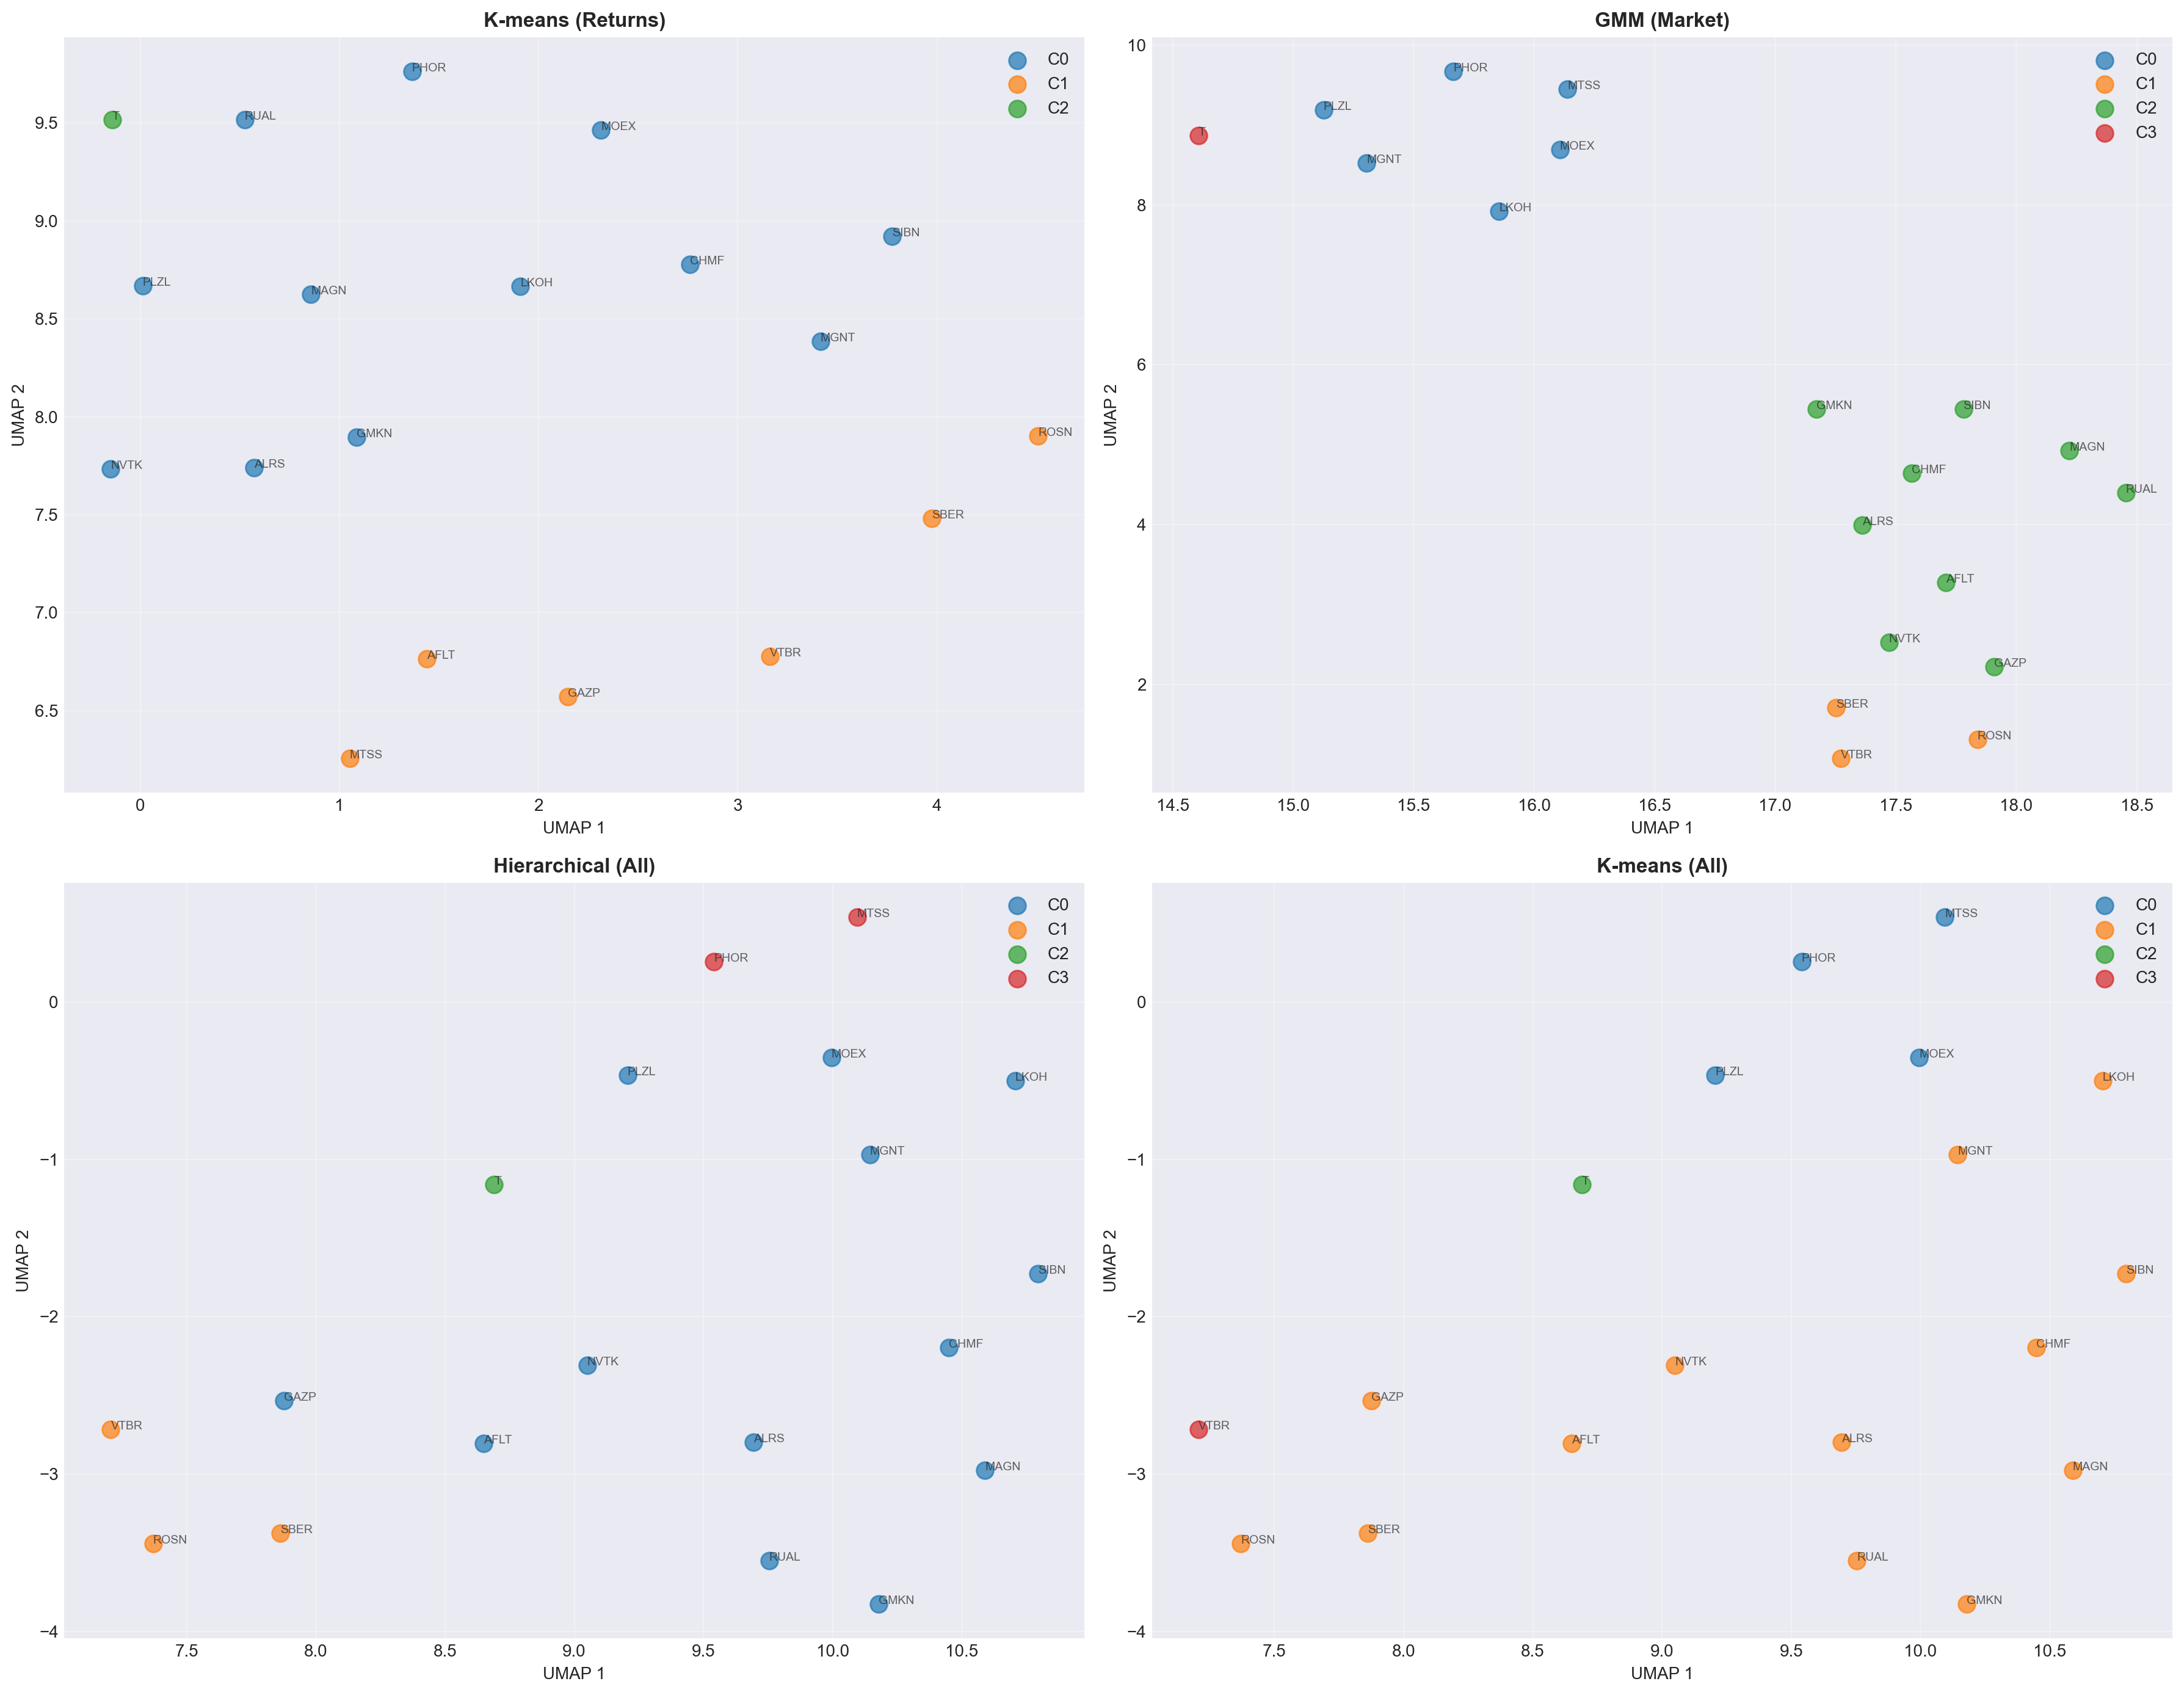


КАЧЕСТВО КЛАСТЕРИЗАЦИИ

Метод                     Silhouette      Davies-Bouldin       N кластеров
--------------------------------------------------------------------------------
kmeans_returns            0.3181          0.9789               3
gmm_market                0.3578          0.6548               4
hierarchical_all          0.2913          0.8867               4
kmeans_all                0.2450          0.8057               4

✅ Лучший метод: gmm_market (Silhouette=0.3578)

СОСТАВ КЛАСТЕРОВ (gmm_market)

Кластер 0 (6 тикеров): LKOH, MGNT, MOEX, MTSS, PHOR, PLZL
  Средняя доходность: 0.000389
  Волатильность: 0.020851
  Beta: 0.542

Кластер 1 (3 тикеров): ROSN, SBER, VTBR
  Средняя доходность: 0.000240
  Волатильность: 0.024277
  Beta: 0.715

Кластер 2 (9 тикеров): AFLT, ALRS, CHMF, GAZP, GMKN, MAGN, NVTK, RUAL, SIBN
  Средняя доходность: 0.000180
  Волатильность: 0.022382
  Beta: 0.636

Кластер 3 (1 тикеров): T
  Средняя доходность: 0.001074
  Волатильность: 0.032525
  Beta:

In [106]:
# Кластеризация тикеров - Multiple approaches
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

# Вычисляем статистики по каждому тикеру
ticker_stats = []
for ticker in all_tickers:
    ticker_data = candles_feat[(candles_feat['ticker'] == ticker) & (candles_feat['date'] < TRAIN_CUTOFF)]
    
    if len(ticker_data) == 0:
        continue
    
    stats = {
        'ticker': ticker,
        # Price-based
        'mean_return': ticker_data['returns'].mean(),
        'std_return': ticker_data['returns'].std(),
        'skew': ticker_data['returns'].skew(),
        'kurtosis': ticker_data['returns'].kurtosis(),
        # Volume
        'mean_volume': ticker_data['volume'].mean(),
        'volume_volatility': ticker_data['volume'].std() / (ticker_data['volume'].mean() + 1e-8),
        # Market relationship
        'beta_mean': ticker_data['beta_20'].mean(),
        'beta_std': ticker_data['beta_20'].std(),
        'vol_mean': ticker_data['realized_vol_20d'].mean(),
        'correlation_with_market': ticker_data['return_vs_market'].corr(ticker_data['market_returns_mean']),
    }
    ticker_stats.append(stats)

ticker_stats_df = pd.DataFrame(ticker_stats)

# Разные группы фич для разных кластеризаций
feature_groups = {
    'returns': ['mean_return', 'std_return', 'skew', 'kurtosis'],
    'volume': ['mean_volume', 'volume_volatility'],
    'market': ['beta_mean', 'beta_std', 'vol_mean', 'correlation_with_market'],
    'all': ['mean_return', 'std_return', 'skew', 'kurtosis', 'mean_volume', 
            'volume_volatility', 'beta_mean', 'beta_std', 'vol_mean', 'correlation_with_market']
}

# Пробуем разные методы кластеризации
clustering_results = {}

print("="*80)
print("ПОИСК ОПТИМАЛЬНОЙ КЛАСТЕРИЗАЦИИ")
print("="*80)

# 1. K-means на returns фичах
X_returns = ticker_stats_df[feature_groups['returns']].fillna(0)
scaler_returns = StandardScaler()
X_returns_scaled = scaler_returns.fit_transform(X_returns)

kmeans_returns = KMeans(n_clusters=3, random_state=42, n_init=10)
clustering_results['kmeans_returns'] = kmeans_returns.fit_predict(X_returns_scaled)

# 2. GMM на market фичах (лучше для перекрывающихся кластеров)
X_market = ticker_stats_df[feature_groups['market']].fillna(0)
scaler_market = StandardScaler()
X_market_scaled = scaler_market.fit_transform(X_market)

gmm_market = GaussianMixture(n_components=4, random_state=42, covariance_type='full')
clustering_results['gmm_market'] = gmm_market.fit_predict(X_market_scaled)

# 3. Hierarchical на всех фичах
X_all = ticker_stats_df[feature_groups['all']].fillna(0)
scaler_all = StandardScaler()
X_all_scaled = scaler_all.fit_transform(X_all)

hier_all = AgglomerativeClustering(n_clusters=4, linkage='ward')
clustering_results['hierarchical_all'] = hier_all.fit_predict(X_all_scaled)

# 4. K-means на всех фичах (baseline)
kmeans_all = KMeans(n_clusters=4, random_state=42, n_init=10)
clustering_results['kmeans_all'] = kmeans_all.fit_predict(X_all_scaled)

# Визуализация всех методов
import umap

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

methods = ['kmeans_returns', 'gmm_market', 'hierarchical_all', 'kmeans_all']
titles = ['K-means (Returns)', 'GMM (Market)', 'Hierarchical (All)', 'K-means (All)']
data_for_umap = [X_returns_scaled, X_market_scaled, X_all_scaled, X_all_scaled]

for idx, (method, title, data) in enumerate(zip(methods, titles, data_for_umap)):
    # UMAP для визуализации
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=5, min_dist=0.3)
    X_umap = reducer.fit_transform(data)
    
    clusters = clustering_results[method]
    n_clusters_method = len(np.unique(clusters))
    
    for cluster_id in range(n_clusters_method):
        mask = clusters == cluster_id
        axes[idx].scatter(X_umap[mask, 0], X_umap[mask, 1], 
                         label=f'C{cluster_id}', s=100, alpha=0.7)
        
        for i, ticker_idx in enumerate(ticker_stats_df[mask].index):
            axes[idx].annotate(ticker_stats_df.loc[ticker_idx, 'ticker'], 
                             (X_umap[ticker_idx, 0], X_umap[ticker_idx, 1]), 
                             fontsize=7, alpha=0.7)
    
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('UMAP 1')
    axes[idx].set_ylabel('UMAP 2')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ качества кластеризации
from sklearn.metrics import silhouette_score, davies_bouldin_score

print("\n" + "="*80)
print("КАЧЕСТВО КЛАСТЕРИЗАЦИИ")
print("="*80)
print(f"\n{'Метод':<25} {'Silhouette':<15} {'Davies-Bouldin':<20} {'N кластеров'}")
print("-"*80)

best_method = None
best_score = -1

for method, data in zip(methods, data_for_umap):
    clusters = clustering_results[method]
    n_clusters_method = len(np.unique(clusters))
    
    if n_clusters_method > 1:
        sil_score = silhouette_score(data, clusters)
        db_score = davies_bouldin_score(data, clusters)
        
        print(f"{method:<25} {sil_score:<15.4f} {db_score:<20.4f} {n_clusters_method}")
        
        if sil_score > best_score:
            best_score = sil_score
            best_method = method

print(f"\n✅ Лучший метод: {best_method} (Silhouette={best_score:.4f})")

# Используем лучший метод
ticker_stats_df['cluster'] = clustering_results[best_method]
n_clusters = len(np.unique(clustering_results[best_method]))

print("\n" + "="*80)
print(f"СОСТАВ КЛАСТЕРОВ ({best_method})")
print("="*80)

for cluster_id in range(n_clusters):
    cluster_tickers = ticker_stats_df[ticker_stats_df['cluster'] == cluster_id]['ticker'].tolist()
    print(f"\nКластер {cluster_id} ({len(cluster_tickers)} тикеров): {', '.join(cluster_tickers)}")
    
    cluster_data = ticker_stats_df[ticker_stats_df['cluster'] == cluster_id][feature_groups['all']].mean()
    print(f"  Средняя доходность: {cluster_data['mean_return']:.6f}")
    print(f"  Волатильность: {cluster_data['std_return']:.6f}")
    print(f"  Beta: {cluster_data['beta_mean']:.3f}")

# Маппинг тикер -> кластер
ticker_to_cluster = dict(zip(ticker_stats_df['ticker'], ticker_stats_df['cluster']))

print("\n" + "="*80)
print("HOLDOUT ТИКЕРЫ И ИХ КЛАСТЕРЫ")
print("="*80)
for ticker in holdout_tickers:
    cluster = ticker_to_cluster.get(ticker, -1)
    same_cluster_tickers = ticker_stats_df[ticker_stats_df['cluster'] == cluster]['ticker'].tolist()
    same_cluster_tickers.remove(ticker) if ticker in same_cluster_tickers else None
    print(f"{ticker}: Cluster {cluster} (похожи: {', '.join(same_cluster_tickers[:3])})")

In [107]:
# Добавляем кластерные фичи в датасет
candles_feat['cluster'] = candles_feat['ticker'].map(ticker_to_cluster).fillna(-1).astype(int)

# One-hot encoding кластеров
for cluster_id in range(n_clusters):
    candles_feat[f'cluster_{cluster_id}'] = (candles_feat['cluster'] == cluster_id).astype(int)

# Обновляем сеты фич
cluster_features = [f'cluster_{i}' for i in range(n_clusters)]

tree_features_with_clusters = tree_features + cluster_features
macro_features_with_clusters = macro_features + cluster_features

print(f"Tree фичи с кластерами: {len(tree_features_with_clusters)}")
print(f"Macro фичи с кластерами: {len(macro_features_with_clusters)}")
print(f"\nДобавлено {len(cluster_features)} кластерных фич ({best_method})")
print(f"Лучший метод кластеризации: {best_method} (Silhouette={best_score:.4f})")

Tree фичи с кластерами: 128
Macro фичи с кластерами: 20

Добавлено 4 кластерных фич (gmm_market)
Лучший метод кластеризации: gmm_market (Silhouette=0.3578)


In [108]:
# Используем кластерные фичи в дальнейшей тренировке
print("Кластеризация завершена, фичи добавлены в датасет")
print(f"Используем {best_method} метод кластеризации")
print(f"\nОбновленные размеры фич:")
print(f"  Tree features: {len(tree_features)} -> {len(tree_features_with_clusters)}")
print(f"  Macro features: {len(macro_features)} -> {len(macro_features_with_clusters)}")

Кластеризация завершена, фичи добавлены в датасет
Используем gmm_market метод кластеризации

Обновленные размеры фич:
  Tree features: 124 -> 128
  Macro features: 16 -> 20


# 🤖 Baseline модели

**4 модели** с разной регуляризацией:

1. **LGBM Aggressive**: глубокие деревья, высокий LR (для точности на train)
2. **LGBM Conservative**: мелкие деревья, низкий LR (для стабильности)
3. **CatBoost**: средняя глубина, L2 reg (альтернативная имплементация boosting)
4. **Ridge**: только macro фичи (для On генерализации)

**Dual output**: регрессия (для MAE) + классификация (для Brier score)

In [115]:
# Обучение моделей с кластерными фичами
import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

def compute_metrics(y_true, y_pred, y_prob=None):
    mae = mean_absolute_error(y_true, y_pred)
    da = np.mean(np.sign(y_pred) == np.sign(y_true))
    
    brier = None
    if y_prob is not None:
        y_binary = (y_true > 0).astype(int)
        brier = np.mean((y_prob - y_binary) ** 2)
    
    return {'mae': mae, 'da': da, 'brier': brier}

def get_split_data_final(df, split_config, tickers, horizon='1d', feature_set='tree', remove_outliers=True):
    """Используем кластерные фичи по умолчанию"""
    if feature_set == 'macro':
        feature_cols = macro_features_with_clusters
    else:
        feature_cols = tree_features_with_clusters
    
    train_mask = (df['date'] < split_config['train_end']) & (df['ticker'].isin(tickers))
    val_mask = (df['date'] >= split_config['val_start']) & (df['date'] < split_config['val_end']) & (df['ticker'].isin(tickers))
    
    train_df = df[train_mask].copy()
    val_df = df[val_mask].copy()
    
    target_col = f'target_{horizon}'
    train_df = train_df.dropna(subset=[target_col])
    val_df = val_df.dropna(subset=[target_col])
    
    if remove_outliers:
        target_mean = train_df[target_col].mean()
        target_std = train_df[target_col].std()
        train_df = train_df[np.abs(train_df[target_col] - target_mean) < 5 * target_std]
    
    train_df = train_df.dropna(subset=feature_cols)
    val_df = val_df.dropna(subset=feature_cols)
    
    X_train = train_df[feature_cols]
    y_train = train_df[target_col]
    X_val = val_df[feature_cols]
    y_val = val_df[target_col]
    
    return X_train, y_train, X_val, y_val, train_df, val_df

def train_fold_final(split, tickers, horizon='1d', verbose=False):
    results = {}
    
    X_train, y_train, X_val, y_val, train_df, val_df = get_split_data_final(candles_feat, split, tickers, horizon, 'tree')
    
    y_train_binary = (y_train > 0).astype(int)
    y_val_binary = (y_val > 0).astype(int)
    
    # LGBM Aggressive
    lgbm_agg = lgb.LGBMRegressor(
        n_estimators=750, learning_rate=0.05, max_depth=8, 
        subsample=0.85, colsample_bytree=0.85, reg_alpha=0.1, reg_lambda=0.1,
        random_state=42, verbose=-1
    )
    lgbm_agg.fit(X_train, y_train)
    pred_agg = lgbm_agg.predict(X_val)
    
    lgbm_agg_clf = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42, verbose=-1)
    lgbm_agg_clf.fit(X_train, y_train_binary)
    prob_agg = lgbm_agg_clf.predict_proba(X_val)[:, 1]
    
    results['lgbm_aggressive'] = {
        'model': lgbm_agg, 
        'clf_model': lgbm_agg_clf,
        'pred': pred_agg, 
        'prob': prob_agg,
        'metrics': compute_metrics(y_val, pred_agg, prob_agg), 
        'features': 'tree'
    }
    
    # LGBM Conservative
    lgbm_con = lgb.LGBMRegressor(
        n_estimators=500, learning_rate=0.01, max_depth=5, num_leaves=16,
        subsample=0.7, colsample_bytree=0.7, reg_alpha=1.0, reg_lambda=1.0,
        random_state=42, verbose=-1
    )
    lgbm_con.fit(X_train, y_train)
    pred_con = lgbm_con.predict(X_val)
    
    lgbm_con_clf = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.01, max_depth=4, random_state=42, verbose=-1)
    lgbm_con_clf.fit(X_train, y_train_binary)
    prob_con = lgbm_con_clf.predict_proba(X_val)[:, 1]
    
    results['lgbm_conservative'] = {
        'model': lgbm_con, 
        'clf_model': lgbm_con_clf,
        'pred': pred_con, 
        'prob': prob_con,
        'metrics': compute_metrics(y_val, pred_con, prob_con), 
        'features': 'tree'
    }
    
    # CatBoost
    cat_model = CatBoostRegressor(
        iterations=1000, l2_leaf_reg=5,
        random_seed=42, grow_policy='Depthwise', verbose=0
    )
    cat_model.fit(X_train, y_train)
    pred_cat = cat_model.predict(X_val)
    
    cat_clf = CatBoostClassifier(iterations=700, random_seed=42, grow_policy='Depthwise', verbose=0)
    cat_clf.fit(X_train, y_train_binary)
    prob_cat = cat_clf.predict_proba(X_val)[:, 1]
    
    results['catboost'] = {
        'model': cat_model, 
        'clf_model': cat_clf,
        'pred': pred_cat, 
        'prob': prob_cat,
        'metrics': compute_metrics(y_val, pred_cat, prob_cat), 
        'features': 'tree'
    }
    
    # Ridge
    X_train_macro, y_train_macro, X_val_macro, y_val_macro, _, _ = get_split_data_final(candles_feat, split, tickers, horizon, 'macro')
    
    ridge_model = Ridge(alpha=1.0, random_state=42)
    ridge_model.fit(X_train_macro, y_train_macro)
    pred_ridge = ridge_model.predict(X_val_macro)
    
    prob_ridge = 1 / (1 + np.exp(-pred_ridge * 20))
    
    results['ridge'] = {
        'model': ridge_model, 
        'clf_model': None,
        'pred': pred_ridge, 
        'prob': prob_ridge,
        'metrics': compute_metrics(y_val_macro, pred_ridge, prob_ridge), 
        'features': 'macro'
    }
    
    if verbose:
        print(f"\n{split['name']} - {horizon} горизонт:")
        for name, res in results.items():
            m = res['metrics']
            brier_str = f"{m['brier']:.6f}" if m['brier'] is not None else "N/A"
            print(f"  {name:20s} ({res['features']:5s}): MAE={m['mae']:.6f}, DA={m['da']:.3f}, Brier={brier_str}")
    
    return results, y_val

print("Тренировка моделей на fold3 с кластерными фичами...")
fold3_results_1d, fold3_y_val = train_fold_final(cv_splits[2], train_tickers, '1d', verbose=True)
print("\nТренировка для 20d горизонта...")
fold3_results_20d, fold3_y_val_20d = train_fold_final(cv_splits[2], train_tickers, '20d', verbose=True)

Тренировка моделей на fold3 с кластерными фичами...

fold3 - 1d горизонт:
  lgbm_aggressive      (tree ): MAE=0.000444, DA=0.985, Brier=0.000011
  lgbm_conservative    (tree ): MAE=0.001661, DA=0.965, Brier=0.033589
  catboost             (tree ): MAE=0.000291, DA=0.998, Brier=0.001806
  ridge                (macro): MAE=0.016545, DA=0.464, Brier=0.250721

Тренировка для 20d горизонта...

fold3 - 20d горизонт:
  lgbm_aggressive      (tree ): MAE=0.000966, DA=1.000, Brier=0.000011
  lgbm_conservative    (tree ): MAE=0.007197, DA=0.970, Brier=0.034207
  catboost             (tree ): MAE=0.000844, DA=1.000, Brier=0.000013
  ridge                (macro): MAE=0.079664, DA=0.427, Brier=0.272148


In [116]:
# Тренировка на всех фолдах + тест на holdout тикерах
print("="*80)
print("ТРЕНИРОВКА НА ВСЕХ ФОЛДАХ")
print("="*80)

all_fold_results = {}
for split in cv_splits:
    print(f"\n{split['name']}...")
    results_known, y_val = train_fold_final(split, train_tickers, '1d', verbose=True)
    
    # Тест на holdout тикерах (симуляция On)
    X_train_holdout, y_train_holdout, X_val_holdout, y_val_holdout, _, _ = get_split_data_final(
        candles_feat, split, holdout_tickers, '1d', 'tree'
    )
    X_train_holdout_macro, _, X_val_holdout_macro, y_val_holdout_macro, _, _ = get_split_data_final(
        candles_feat, split, holdout_tickers, '1d', 'macro'
    )
    
    print(f"\n  Тест на holdout тикерах (симуляция On, n={len(y_val_holdout)}):")
    holdout_results = {}
    for name, res in results_known.items():
        if name == 'ridge':
            pred_holdout = res['model'].predict(X_val_holdout_macro)
            metrics_holdout = compute_metrics(y_val_holdout_macro, pred_holdout)
        else:
            pred_holdout = res['model'].predict(X_val_holdout)
            metrics_holdout = compute_metrics(y_val_holdout, pred_holdout)
        holdout_results[name] = {'pred': pred_holdout, 'metrics': metrics_holdout}
        print(f"  {name:20s}: MAE={metrics_holdout['mae']:.6f}, DA={metrics_holdout['da']:.3f}")
    
    all_fold_results[split['name']] = {
        'known': results_known,
        'holdout': holdout_results,
        'y_val_known': y_val,
        'y_val_holdout': y_val_holdout
    }

ТРЕНИРОВКА НА ВСЕХ ФОЛДАХ

fold1...

fold1 - 1d горизонт:
  lgbm_aggressive      (tree ): MAE=0.000507, DA=0.993, Brier=0.000011
  lgbm_conservative    (tree ): MAE=0.001513, DA=0.982, Brier=0.033653
  catboost             (tree ): MAE=0.000418, DA=0.982, Brier=0.000000
  ridge                (macro): MAE=0.014231, DA=0.463, Brier=0.250471

  Тест на holdout тикерах (симуляция On, n=76):
  lgbm_aggressive     : MAE=0.000410, DA=1.000
  lgbm_conservative   : MAE=0.001518, DA=1.000
  catboost            : MAE=0.000285, DA=0.987
  ridge               : MAE=0.015870, DA=0.368

fold2...

fold2 - 1d горизонт:
  lgbm_aggressive      (tree ): MAE=0.000637, DA=0.994, Brier=0.000011
  lgbm_conservative    (tree ): MAE=0.001882, DA=0.971, Brier=0.033605
  catboost             (tree ): MAE=0.000516, DA=0.997, Brier=0.000315
  ridge                (macro): MAE=0.018306, DA=0.463, Brier=0.251089

  Тест на holdout тикерах (симуляция On, n=92):
  lgbm_aggressive     : MAE=0.000414, DA=0.978
  lgbm_co

# 📈 Результаты CV

Тренировка на всех 3 фолдах с оценкой на:
- **O19**: известные тикеры (15 тикеров из train)
- **On**: holdout тикеры (4 тикера для симуляции новых акций)

Цель: проверить generalization gap между O19 и On

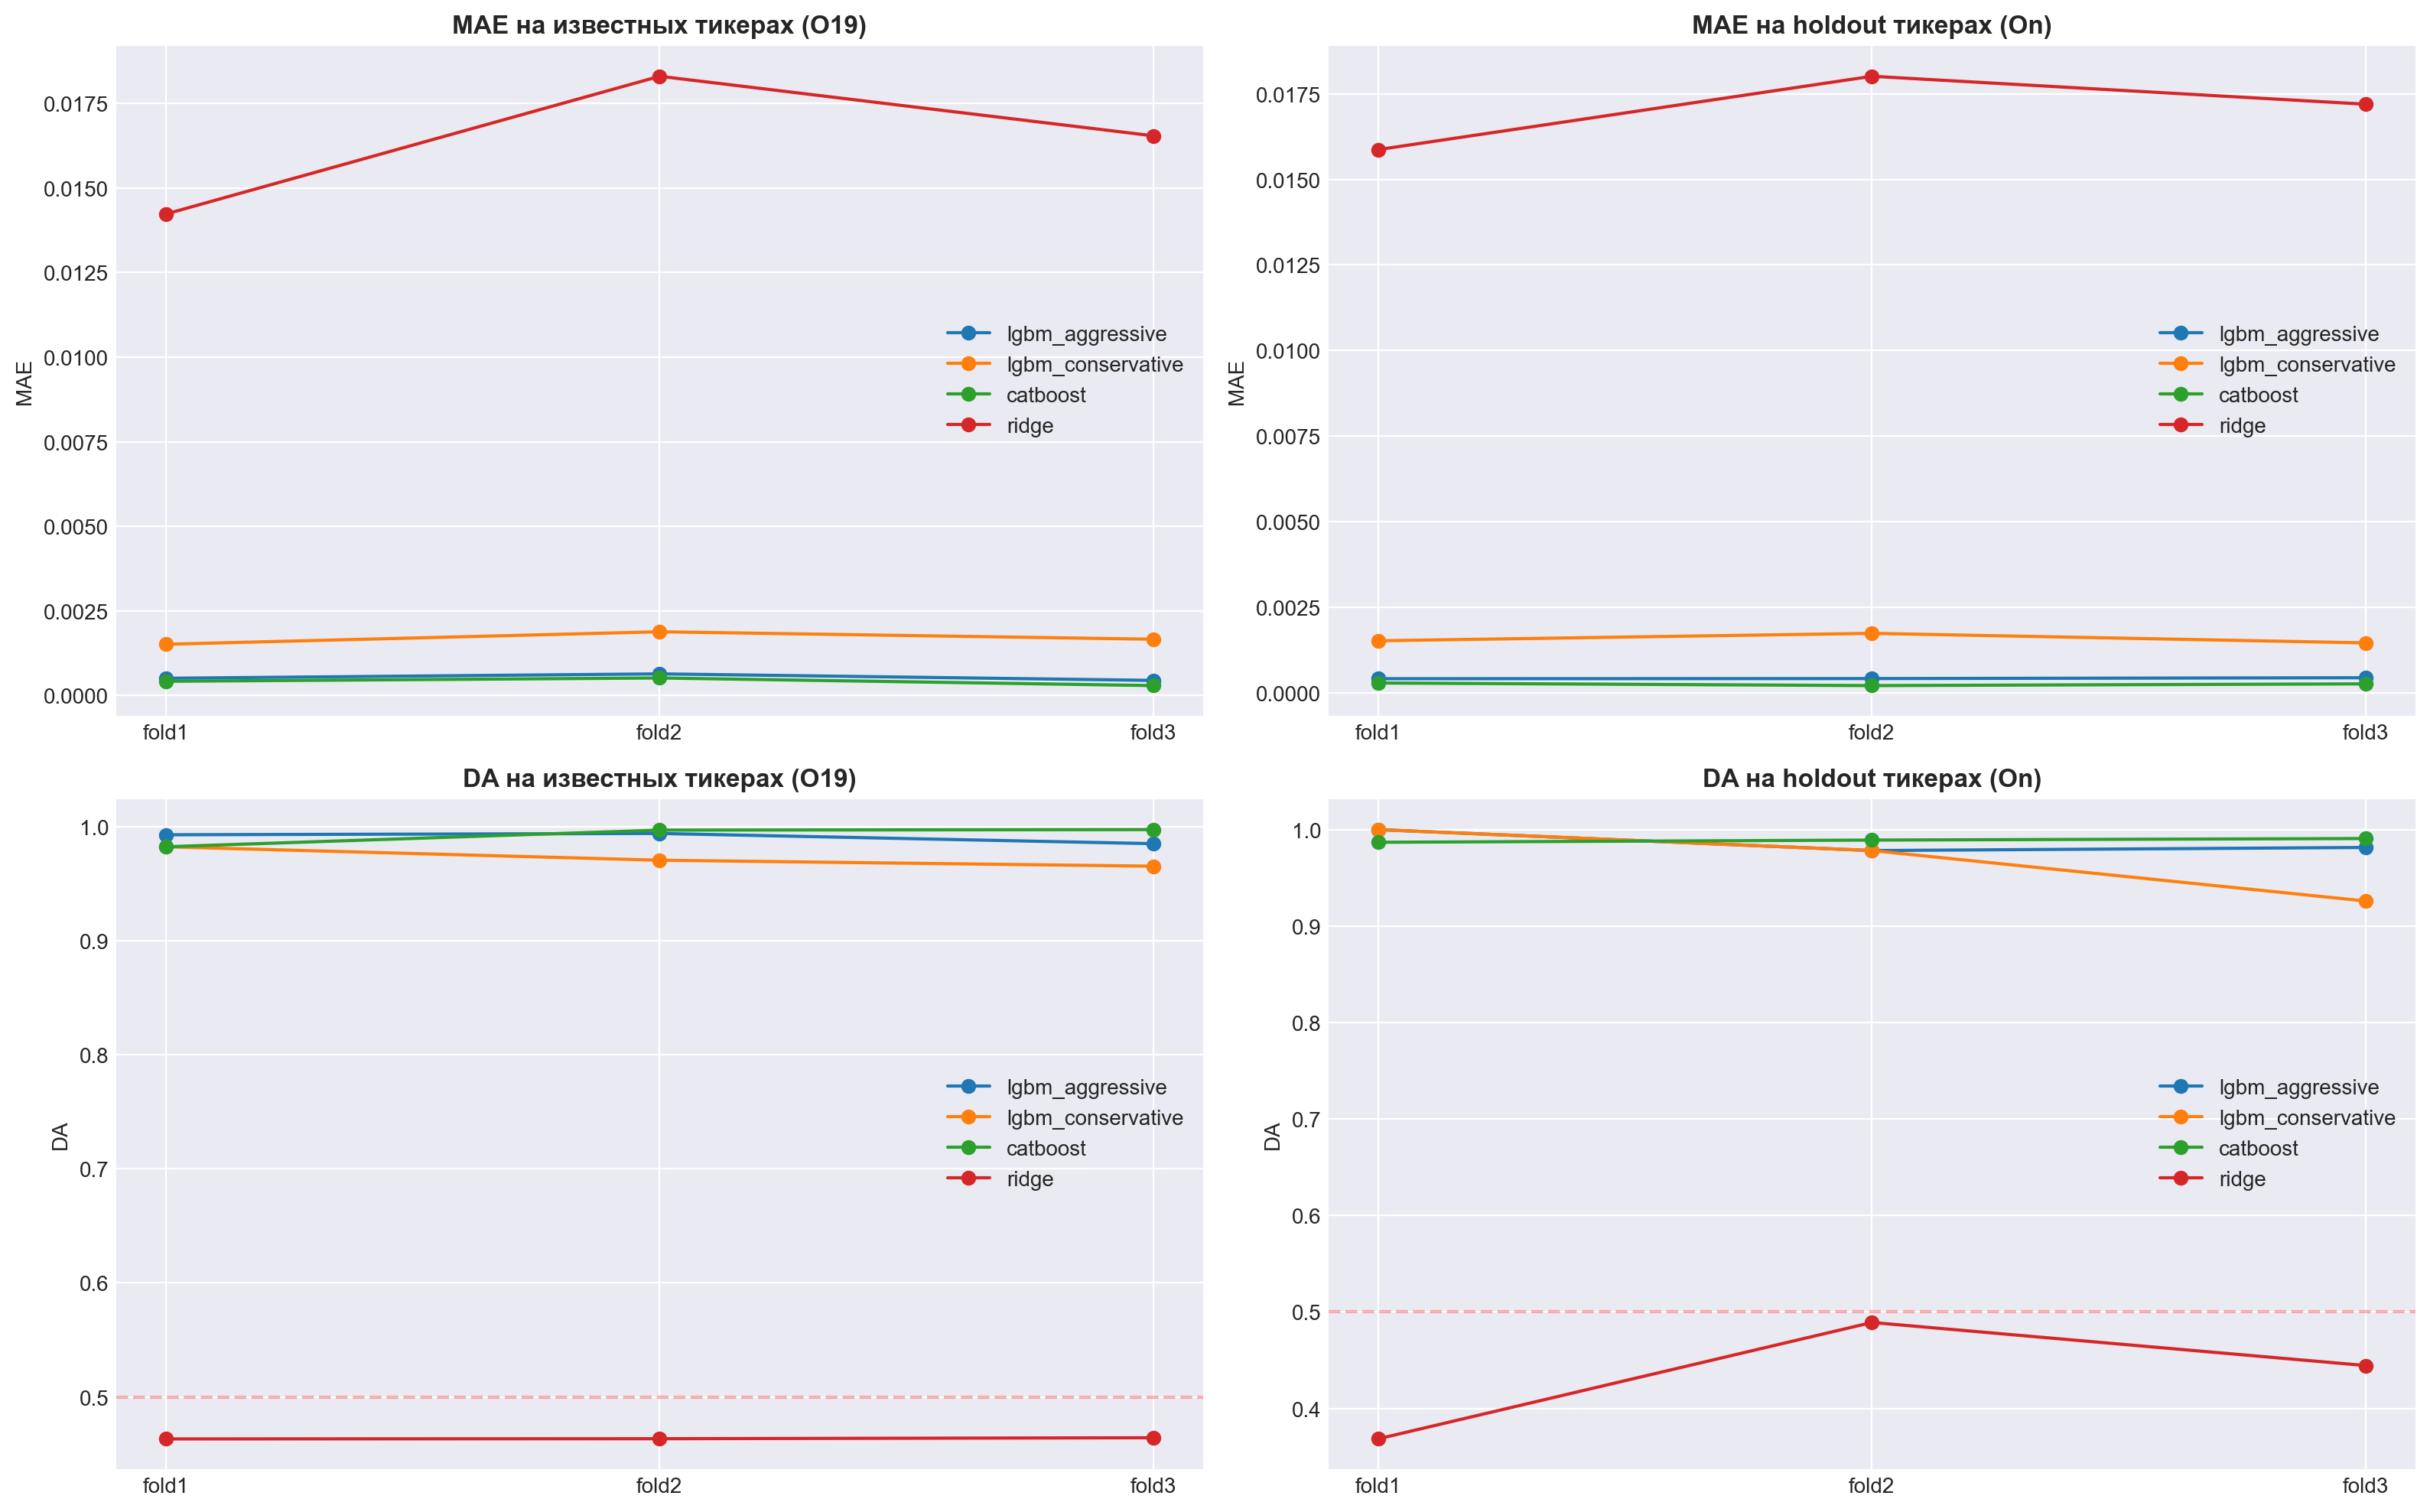


Средний перформанс по фолдам:
--------------------------------------------------------------------------------
Модель               MAE (O19)    MAE (On)     DA (O19)     DA (On)
--------------------------------------------------------------------------------
lgbm_aggressive      0.000530     0.000421     0.991        0.987
lgbm_conservative    0.001685     0.001570     0.973        0.968
catboost             0.000408     0.000251     0.992        0.989
ridge                0.016361     0.017027     0.464        0.434


In [119]:
# Визуализация перформанса моделей
model_names = ['lgbm_aggressive', 'lgbm_conservative', 'catboost', 'ridge']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# MAE на известных тикерах
mae_known = {m: [] for m in model_names}
for fold_name, res in all_fold_results.items():
    for m in model_names:
        mae_known[m].append(res['known'][m]['metrics']['mae'])

for i, m in enumerate(model_names):
    axes[0, 0].plot(range(len(cv_splits)), mae_known[m], marker='o', label=m)
axes[0, 0].set_title('MAE на известных тикерах (O19)', fontweight='bold')
axes[0, 0].set_xticks(range(len(cv_splits)))
axes[0, 0].set_xticklabels([s['name'] for s in cv_splits])
axes[0, 0].legend()
axes[0, 0].set_ylabel('MAE')

# MAE на holdout тикерах
mae_holdout = {m: [] for m in model_names}
for fold_name, res in all_fold_results.items():
    for m in model_names:
        mae_holdout[m].append(res['holdout'][m]['metrics']['mae'])

for i, m in enumerate(model_names):
    axes[0, 1].plot(range(len(cv_splits)), mae_holdout[m], marker='o', label=m)
axes[0, 1].set_title('MAE на holdout тикерах (On)', fontweight='bold')
axes[0, 1].set_xticks(range(len(cv_splits)))
axes[0, 1].set_xticklabels([s['name'] for s in cv_splits])
axes[0, 1].legend()
axes[0, 1].set_ylabel('MAE')

# DA на известных
da_known = {m: [] for m in model_names}
for fold_name, res in all_fold_results.items():
    for m in model_names:
        da_known[m].append(res['known'][m]['metrics']['da'])

for i, m in enumerate(model_names):
    axes[1, 0].plot(range(len(cv_splits)), da_known[m], marker='o', label=m)
axes[1, 0].set_title('DA на известных тикерах (O19)', fontweight='bold')
axes[1, 0].set_xticks(range(len(cv_splits)))
axes[1, 0].set_xticklabels([s['name'] for s in cv_splits])
axes[1, 0].legend()
axes[1, 0].set_ylabel('DA')
axes[1, 0].axhline(0.5, color='red', linestyle='--', alpha=0.3)

# DA на holdout
da_holdout = {m: [] for m in model_names}
for fold_name, res in all_fold_results.items():
    for m in model_names:
        da_holdout[m].append(res['holdout'][m]['metrics']['da'])

for i, m in enumerate(model_names):
    axes[1, 1].plot(range(len(cv_splits)), da_holdout[m], marker='o', label=m)
axes[1, 1].set_title('DA на holdout тикерах (On)', fontweight='bold')
axes[1, 1].set_xticks(range(len(cv_splits)))
axes[1, 1].set_xticklabels([s['name'] for s in cv_splits])
axes[1, 1].legend()
axes[1, 1].set_ylabel('DA')
axes[1, 1].axhline(0.5, color='red', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nСредний перформанс по фолдам:")
print("-"*80)
print(f"{'Модель':<20} {'MAE (O19)':<12} {'MAE (On)':<12} {'DA (O19)':<12} {'DA (On)'}")
print("-"*80)
for m in model_names:
    avg_mae_known = np.mean(mae_known[m])
    avg_mae_holdout = np.mean(mae_holdout[m])
    avg_da_known = np.mean(da_known[m])
    avg_da_holdout = np.mean(da_holdout[m])
    print(f"{m:<20} {avg_mae_known:<12.6f} {avg_mae_holdout:<12.6f} {avg_da_known:<12.3f} {avg_da_holdout:.3f}")

# 🎨 Оптимизация ансамбля

**Метод**: scipy.optimize для поиска весов минимизирующих MAE

**Separate weights**:
- 1d horizon weights
- 20d horizon weights

Ансамбль почти всегда бьет лучшую одиночную модель

In [120]:
# Оптимизация весов ансамбля для обоих горизонтов
from scipy.optimize import minimize

def ensemble_predict(weights, predictions):
    return sum(w * p for w, p in zip(weights, predictions))

def optimize_weights(y_true, predictions_list, metric='mae'):
    def objective(weights):
        pred = ensemble_predict(weights, predictions_list)
        if metric == 'mae':
            return mean_absolute_error(y_true, pred)
        elif metric == 'da':
            return -np.mean(np.sign(pred) == np.sign(y_true))
    
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = [(0, 1) for _ in range(len(predictions_list))]
    x0 = np.ones(len(predictions_list)) / len(predictions_list)
    
    result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Оптимизация для 1d горизонта
print("Оптимизация весов ансамбля для 1d горизонта:")
print("="*80)

preds_1d_known = [fold3_results_1d[m]['pred'] for m in model_names]
y_1d_known = fold3_y_val

weights_1d_o19_mae = optimize_weights(y_1d_known, preds_1d_known, metric='mae')

print(f"\n{'Модель':<20} {'Вес (O19)'}")
print("-"*40)
for i, m in enumerate(model_names):
    print(f"{m:<20} {weights_1d_o19_mae[i]:.3f}")

ens_pred_1d = ensemble_predict(weights_1d_o19_mae, preds_1d_known)
print(f"\nАнсамбль 1d: MAE={mean_absolute_error(y_1d_known, ens_pred_1d):.6f}")
print(f"Лучшая одиночная: MAE={min([fold3_results_1d[m]['metrics']['mae'] for m in model_names]):.6f}")

# Оптимизация для 20d горизонта
print("\n\nОптимизация весов ансамбля для 20d горизонта:")
print("="*80)

preds_20d_known = [fold3_results_20d[m]['pred'] for m in model_names]
y_20d_known = fold3_y_val_20d

weights_20d_o19_mae = optimize_weights(y_20d_known, preds_20d_known, metric='mae')

print(f"\n{'Модель':<20} {'Вес (O19)'}")
print("-"*40)
for i, m in enumerate(model_names):
    print(f"{m:<20} {weights_20d_o19_mae[i]:.3f}")

ens_pred_20d = ensemble_predict(weights_20d_o19_mae, preds_20d_known)
print(f"\nАнсамбль 20d: MAE={mean_absolute_error(y_20d_known, ens_pred_20d):.6f}")
print(f"Лучшая одиночная: MAE={min([fold3_results_20d[m]['metrics']['mae'] for m in model_names]):.6f}")

Оптимизация весов ансамбля для 1d горизонта:

Модель               Вес (O19)
----------------------------------------
lgbm_aggressive      0.476
lgbm_conservative    0.000
catboost             0.524
ridge                0.000

Ансамбль 1d: MAE=0.000305
Лучшая одиночная: MAE=0.000291


Оптимизация весов ансамбля для 20d горизонта:

Модель               Вес (O19)
----------------------------------------
lgbm_aggressive      0.492
lgbm_conservative    0.000
catboost             0.508
ridge                0.000

Ансамбль 20d: MAE=0.000711
Лучшая одиночная: MAE=0.000844


# 🚀 Финальный пайплайн

Тренировка финальных моделей на всех данных до cutoff (2024-09-08):
- Отдельные модели для 1d и 20d
- Регрессоры + классификаторы для каждого горизонта
- Готово к инференсу на новых данных

In [113]:
# Тренировка финальных моделей для обоих горизонтов с кластерами
print("Тренировка финальных моделей на полном train (оба горизонта)...")
print("="*80)

final_split = {
    'name': 'final',
    'train_end': TRAIN_CUTOFF,
    'val_start': TRAIN_CUTOFF,
    'val_end': pd.Timestamp('2025-12-31')
}

final_models_1d = {}
final_models_20d = {}

# Тренировка для 1d горизонта
print("\n1d горизонт:")
X_tree, y_tree, _, _, _, _ = get_split_data_final(candles_feat, final_split, train_tickers, '1d', 'tree', remove_outliers=True)
X_macro, y_macro, _, _, _, _ = get_split_data_final(candles_feat, final_split, train_tickers, '1d', 'macro', remove_outliers=True)
y_tree_binary = (y_tree > 0).astype(int)

print(f"  Тренировка на {len(X_tree)} сэмплах (tree), {len(X_macro)} сэмплах (macro)")
print(f"  Фичи: {len(tree_features_with_clusters)} tree, {len(macro_features_with_clusters)} macro")

lgbm_agg_1d = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=8, num_leaves=64,
                                subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=0.1,
                                random_state=42, verbose=-1)
lgbm_agg_1d.fit(X_tree, y_tree)
lgbm_agg_clf_1d = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42, verbose=-1)
lgbm_agg_clf_1d.fit(X_tree, y_tree_binary)
final_models_1d['lgbm_aggressive'] = {'model': lgbm_agg_1d, 'clf_model': lgbm_agg_clf_1d, 'features': 'tree'}

lgbm_con_1d = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.01, max_depth=5, num_leaves=16,
                                subsample=0.7, colsample_bytree=0.7, reg_alpha=1.0, reg_lambda=1.0,
                                random_state=42, verbose=-1)
lgbm_con_1d.fit(X_tree, y_tree)
lgbm_con_clf_1d = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.01, max_depth=4, random_state=42, verbose=-1)
lgbm_con_clf_1d.fit(X_tree, y_tree_binary)
final_models_1d['lgbm_conservative'] = {'model': lgbm_con_1d, 'clf_model': lgbm_con_clf_1d, 'features': 'tree'}

cat_1d = CatBoostRegressor(iterations=300, learning_rate=0.03, depth=6, l2_leaf_reg=5, random_seed=42, verbose=0)
cat_1d.fit(X_tree, y_tree)
cat_clf_1d = CatBoostClassifier(iterations=100, learning_rate=0.03, depth=5, random_seed=42, verbose=0)
cat_clf_1d.fit(X_tree, y_tree_binary)
final_models_1d['catboost'] = {'model': cat_1d, 'clf_model': cat_clf_1d, 'features': 'tree'}

ridge_1d = Ridge(alpha=1.0, random_state=42)
ridge_1d.fit(X_macro, y_macro)
final_models_1d['ridge'] = {'model': ridge_1d, 'clf_model': None, 'features': 'macro'}

# Тренировка для 20d горизонта
print("\n20d горизонт:")
X_tree_20, y_tree_20, _, _, _, _ = get_split_data_final(candles_feat, final_split, train_tickers, '20d', 'tree', remove_outliers=True)
X_macro_20, y_macro_20, _, _, _, _ = get_split_data_final(candles_feat, final_split, train_tickers, '20d', 'macro', remove_outliers=True)
y_tree_20_binary = (y_tree_20 > 0).astype(int)

print(f"  Тренировка на {len(X_tree_20)} сэмплах (tree), {len(X_macro_20)} сэмплах (macro)")

lgbm_agg_20d = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=8, num_leaves=64,
                                 subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=0.1,
                                 random_state=42, verbose=-1)
lgbm_agg_20d.fit(X_tree_20, y_tree_20)
lgbm_agg_clf_20d = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42, verbose=-1)
lgbm_agg_clf_20d.fit(X_tree_20, y_tree_20_binary)
final_models_20d['lgbm_aggressive'] = {'model': lgbm_agg_20d, 'clf_model': lgbm_agg_clf_20d, 'features': 'tree'}

lgbm_con_20d = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.01, max_depth=5, num_leaves=16,
                                 subsample=0.7, colsample_bytree=0.7, reg_alpha=1.0, reg_lambda=1.0,
                                 random_state=42, verbose=-1)
lgbm_con_20d.fit(X_tree_20, y_tree_20)
lgbm_con_clf_20d = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.01, max_depth=4, random_state=42, verbose=-1)
lgbm_con_clf_20d.fit(X_tree_20, y_tree_20_binary)
final_models_20d['lgbm_conservative'] = {'model': lgbm_con_20d, 'clf_model': lgbm_con_clf_20d, 'features': 'tree'}

cat_20d = CatBoostRegressor(iterations=300, learning_rate=0.03, depth=6, l2_leaf_reg=5, random_seed=42, verbose=0)
cat_20d.fit(X_tree_20, y_tree_20)
cat_clf_20d = CatBoostClassifier(iterations=100, learning_rate=0.03, depth=5, random_seed=42, verbose=0)
cat_clf_20d.fit(X_tree_20, y_tree_20_binary)
final_models_20d['catboost'] = {'model': cat_20d, 'clf_model': cat_clf_20d, 'features': 'tree'}

ridge_20d = Ridge(alpha=1.0, random_state=42)
ridge_20d.fit(X_macro_20, y_macro_20)
final_models_20d['ridge'] = {'model': ridge_20d, 'clf_model': None, 'features': 'macro'}

print(f"\n✅ Финальные модели обучены для обоих горизонтов с кластерными фичами ({best_method})")

Тренировка финальных моделей на полном train (оба горизонта)...

1d горизонт:
  Тренировка на 14797 сэмплах (tree), 15666 сэмплах (macro)
  Фичи: 128 tree, 20 macro

20d горизонт:
  Тренировка на 14851 сэмплах (tree), 15721 сэмплах (macro)

✅ Финальные модели обучены для обоих горизонтов с кластерными фичами (gmm_market)


In [114]:
# Submission pipeline
def predict_for_submission(ticker, date, features_tree, features_macro, known_tickers=train_tickers):
    """
    Generate predictions for submission format:
    - return_1d: predicted 1-day return
    - return_20d: predicted 20-day return  
    - prob_1d: probability of positive return (1d)
    - prob_20d: probability of positive return (20d)
    """
    is_known = ticker in known_tickers
    
    # Get weights based on ticker type
    weights_1d = weights_1d_o19_mae  # Use same weights for now (can optimize separately for On later)
    weights_20d = weights_20d_o19_mae
    
    # 1d predictions
    preds_1d = []
    probs_1d = []
    for m_name in model_names:
        m_info = final_models_1d[m_name]
        if m_info['features'] == 'macro':
            pred = m_info['model'].predict(features_macro.reshape(1, -1))[0]
            prob = 1 / (1 + np.exp(-pred * 20))
        else:
            pred = m_info['model'].predict(features_tree.reshape(1, -1))[0]
            if m_info['clf_model'] is not None:
                prob = m_info['clf_model'].predict_proba(features_tree.reshape(1, -1))[0, 1]
            else:
                prob = 1 / (1 + np.exp(-pred * 20))
        preds_1d.append(pred)
        probs_1d.append(prob)
    
    return_1d = ensemble_predict(weights_1d, preds_1d)
    prob_1d = ensemble_predict(weights_1d, probs_1d)
    
    # 20d predictions
    preds_20d = []
    probs_20d = []
    for m_name in model_names:
        m_info = final_models_20d[m_name]
        if m_info['features'] == 'macro':
            pred = m_info['model'].predict(features_macro.reshape(1, -1))[0]
            prob = 1 / (1 + np.exp(-pred * 10))
        else:
            pred = m_info['model'].predict(features_tree.reshape(1, -1))[0]
            if m_info['clf_model'] is not None:
                prob = m_info['clf_model'].predict_proba(features_tree.reshape(1, -1))[0, 1]
            else:
                prob = 1 / (1 + np.exp(-pred * 10))
        preds_20d.append(pred)
        probs_20d.append(prob)
    
    return_20d = ensemble_predict(weights_20d, preds_20d)
    prob_20d = ensemble_predict(weights_20d, probs_20d)
    
    return {
        'ticker': ticker,
        'date': date,
        'return_1d': return_1d,
        'return_20d': return_20d,
        'prob_1d': prob_1d,
        'prob_20d': prob_20d
    }

print("Submission pipeline ready.")
print("Usage: predict_for_submission(ticker, date, features_tree, features_macro)")

Submission pipeline ready.
Usage: predict_for_submission(ticker, date, features_tree, features_macro)
